In [1]:
#necessary package
import time
import os
import numpy as np
import pandas as pd
from scipy.stats.mstats import winsorize
import scipy.stats as stats
from itertools import groupby
from scipy.stats import kurtosis, skew, entropy
from scipy.signal import medfilt, find_peaks
from numpy.fft import fft, rfft, rfftfreq
from tqdm import tqdm
from datetime import datetime
import pyodbc 
import multiprocessing
from joblib import Parallel, delayed

#Import Visualization Modules
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from IPython.display import display, HTML
%matplotlib inline


#Import Machine Learning packages

from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut, LeavePOut, StratifiedShuffleSplit, GridSearchCV, RepeatedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Binarizer, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, f1_score,precision_score, recall_score, roc_curve, auc, accuracy_score,mean_absolute_error, r2_score, roc_auc_score,log_loss,precision_recall_curve,precision_recall_fscore_support
from sklearn import ensemble, tree
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree,callback, plot_importance
from xgboost.callback import EarlyStopping
from sklearn import pipeline
import m2cgen as m2c
import optuna
from optuna.integration import XGBoostPruningCallback
from xgboost.callback import EarlyStopping as XgbEarlyStopping
import shap


#Import warning
import warnings
warnings.simplefilter("ignore")

np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


#import and load model
import pickle
import joblib

# Notebook display
try:
    from IPython.display import display, HTML
    _HAS_IPY = True
except Exception:
    _HAS_IPY = False


RANDOM_STATE = 42

In [2]:
# Select the working directory (the folder where your notebook is running)
working_directory = os.getcwd()  # Get the current working directory path
print(working_directory)  # Print the working directory to confirm

/mnt/batch/tasks/shared/LS_root/mounts/clusters/andrewgpu/code/Users/apham/mvt ml model + detect graph point


# Load data from BMIS2

In [3]:

# Connection parameters
server = 'prod-bmis2-sqlserver.database.windows.net'
database = 'BMIS2'  # Change if your database name differs
username = 'DataIntern'
password = 'D@ta!ntern@mdx1'
driver = '{ODBC Driver 18 for SQL Server}'  # or '{ODBC Driver 18 for SQL Server}'

# Build connection string and connect
conn_str = (
    f"DRIVER={driver};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password}"
)
conn = pyodbc.connect(conn_str)


mvt = '''
SELECT  t.TestRecordDetailId as "Test_Record_Detail_ID", SoftwareVersionNumber,
Voltage, Rated, Measured,g.StarterVoltageGraphpoints, g.AlternatorRippleGraphpoints, BatteryDecision as "Battery_Decision"
FROM BMIS.R_T_TestRecordDetails as t
left join BMIS.R_T_TestRecordLineItemDetail as l on t.TestRecordDetailId=l.TestRecordDetailId
left join BMIS.R_T_TestsGraphPoints as g on g.KeyID=l.GraphpointKeyID
where t.clientid not in (160, 10, 2123, 1, 12345)
and t.TestDate >='01/01/2023'
and t.TestDate <= getdate()
and StarterVoltageGraphpoints is not null
and StarterVoltageGraphpoints like '%:%'
and t.Voltage > 0
and t.Measured > 0
and t.ToolTypeID = 7
and t.BatteryDecision in (0,1,5,6)
'''

# Execute query and load results into a DataFrame
MVT_Original = pd.read_sql(mvt, conn)

# Close connection
conn.close()


In [4]:

bd_map = {  0: "GOOD BATTERY",
    1: "GOOD RECHARGE",
    2: "MARGINAL RECHARGE",
    3: "MARGINAL",
    4: "CHARGE & RETES",
    5: "REPLACE BATTERY",
    6: "BADCELL SHORT REPLACE",
    7: "REMOTE POST",
    8: "SIDE POST",
    9: "BC OPEN OR LOAD FAIL REPLACE",
    10: "BROKEN WELD REPLACE",
    11: "FROZEN BATTERY",
    12: "TOO HOT REPLACE",
    13: "TEMP SENSOR FAILED",
    14: "ABORTED",
    15: "INVALID TEST",
    16: "ABORTED/24V",
    17: "OUT OF BALANCE",
    15: "IN BALANCE",
    16: "CLAMPS REMOVED",
    20: "LOST POWER",
    21: "CHARGE & RETEST QUESTION",
    22: "SIDE POST QUESTION",
    23: "SYSTEM NOISE",
    24: "JUMPER POST QUESTION",
    25: "GOOD PACK",
    26: "CHECK PACK",
    27: "BADCELL SHORT",
    28: "To be reused",
    29: "READY TO INSTALL",
    30: "DECISION NOT REACHED",
    31: "PDI COMPLETE",
    32: "CYCLING REQUIRED",
    33: "REST & RETEST",
    34: "To be reused",
    35: "To be reused",
    36: "Replace SRFCHG",
    37: "Good SRFCHG",
    38: "GR-8 Diag SRFCHG",
    39: "Good Rech SRFCHG",
    100: "GOOD BATTERY",
    101: "GOOD RECHARGE",
    102: "MARGINAL RECHARGE",
    103: "MARGINAL",
    104: "CHARGE & RETEST",
    105: "REPLACE BATTERY",
    106: "BADCELL SHORT REPLACE",
    107: "REMOTE POST",
    108: "SIDE POST",
    109: "BC OPEN OR LOAD FAIL REPLACE",
    110: "BROKEN WELD REPLACE",
    111: "FROZEN BATTERY",
    112: "TOO HOT REPLACE",
    113: "TEMP SENSOR FAILED",
    114: "ABORTED",
    115: "INVALID TEST",
    116: "ABORTED/24V",
    117: "OUT OF BALANCE",
    118: "IN BALANCE",
    119: "CLAMPS REMOVED",
    120: "LOST POWER",
    121: "PDI COMPLETE",
    122: "POOR RESERVE",
    123: "GOOD RESERVE",
    124: "POOR CHARGE ACCEPTANCE",
    125: "GOOD CHARGE ACCEPTANCE",
    126: "NO DECISION",
    136: "Stopped",
    249: "CUSTOMER DECISION 5",
    250: "CUSTOMER DECISION 4",
    251: "CUSTOMER DECISION 3",
    252: "CUSTOMER DECISION 2",
    253: "CUSTOMER DECISION 1",
    254: "ALL BATTERY AND CHARGE DECISIONS",
    255: "No Decision"
           }

decision = ['GOOD BATTERY', 'GOOD RECHARGE', 'REPLACE BATTERY', 'CHARGE & RETEST', 'BADCELL SHORT REPLACE']  

MVT_Original.dropna(inplace=True)
MVT_Original.drop_duplicates(inplace=True)
MVT_Original.reset_index(drop=True, inplace=True)

MVT_Original['Battery_Decision'] = MVT_Original['Battery_Decision'].astype(int)
MVT_Original['Battery_Decision'] = MVT_Original['Battery_Decision'].map(bd_map)


In [5]:
#convert good and bad battery
good = ['GOOD BATTERY','GOOD RECHARGE']
bad = ['REPLACE BATTERY','BADCELL SHORT REPLACE']

def batterydecision(status):
    if status in good:
        return 'GOOD BATTERY'
    elif status in bad:
        return 'BAD BATTERY'
    else:
        return status
    
MVT_Original['Battery_Decision'] = MVT_Original['Battery_Decision'].apply(batterydecision)

MVT_Original = MVT_Original[MVT_Original['Battery_Decision'].isin(['GOOD BATTERY', 'BAD BATTERY'])]

display(MVT_Original['Battery_Decision'].value_counts())
display(MVT_Original.info())

Battery_Decision
GOOD BATTERY    14571
BAD BATTERY      3510
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18081 entries, 0 to 18080
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Test_Record_Detail_ID        18081 non-null  int64  
 1   SoftwareVersionNumber        18081 non-null  object 
 2   Voltage                      18081 non-null  float64
 3   Rated                        18081 non-null  int64  
 4   Measured                     18081 non-null  int64  
 5   StarterVoltageGraphpoints    18081 non-null  object 
 6   AlternatorRippleGraphpoints  18081 non-null  object 
 7   Battery_Decision             18081 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 1.1+ MB


None

In [6]:
#Split and expand the StarterVoltageGraphpoints column
Starter_Voltage_Array_MVT = MVT_Original['StarterVoltageGraphpoints'].str.split(':', expand=True)
Starter_Voltage_Array_MVT['SoftwareVersionNumber'] = MVT_Original['SoftwareVersionNumber']
Starter_Voltage_Array_MVT.fillna(value='nan',inplace=True)
Starter_Voltage_Array_MVT.dropna(thresh=20,inplace=True)

In [7]:
alternator_ripple_array = MVT_Original.AlternatorRippleGraphpoints.str.split(':', expand=True)

In [8]:
def hex_to_signed_int(h: str) -> int:
    """
    Convert an 8-digit hex string (two’s-complement 32-bit) into a Python int.
    """
    val = int(h, 16)               # Python int, never overflows
    if val & 0x80000000:           # if sign bit set
        val -= 0x100000000        # subtract 2**32
    return val

In [9]:
#drop rows where the hex value is greater than or less than 8 characters
alternator_ripple_array = alternator_ripple_array.applymap(lambda x: x if isinstance(x, str) and len(x) == 8 else None)
alternator_ripple_array = alternator_ripple_array.applymap(hex_to_signed_int, na_action='ignore')

In [10]:
alternator_ripple_array['Test_Record_Detail_ID'] = MVT_Original['Test_Record_Detail_ID']

In [11]:
# Map of software version numbers to their hex status
version_is_hex  = {
    '192-113153B': True,
    '192-113153A': True,
    '192-113075A': True,
    '192-113007B': False,
    '192-113007A': False,
    '192-112922E': True,
    '192-112922F': True,
    '192-113201A': True,
    '192-113089B': True,
    '192-113075C': True,
    '192-113201B': True,
    '192-113201A': True,
    '192-113153C': True,
    '192-113089A': False,
}

# ── converters ────────────────────────────────────────────────────────────────
def _hex_convert(val):
    """Convert a single value from hex, dividing by 100."""
    try:
        if pd.isna(val):
            return np.nan
        return int(str(val), 16) / 100
    except Exception:
        return np.nan

def _dec_convert(val):
    """Convert a single numeric value (decimal), dividing by 100."""
    try:
        if pd.isna(val):
            return np.nan
        return float(val) / 100
    except Exception:
        return np.nan

# ── chunk processor ───────────────────────────────────────────────────────────
def process_chunk(df_chunk: pd.DataFrame) -> pd.DataFrame:
    # Ensure 'SoftwareVersionNumber' column is inferred to appropriate type
    df_chunk['SoftwareVersionNumber'] = df_chunk['SoftwareVersionNumber'].infer_objects()

    # 1) determine for each row whether its SoftwareVersionNumber uses hex
    is_hex_row = df_chunk['SoftwareVersionNumber'] \
                     .map(version_is_hex) \
                     .fillna(False)  # unknown versions → decimal

    # 2) pick out all voltage columns (everything except the version column)
    voltage_cols = [c for c in df_chunk.columns if c != 'SoftwareVersionNumber']

    # 3) apply hex convert to hex‐rows, decimal convert to the rest
    df_chunk.loc[is_hex_row, voltage_cols]  = df_chunk.loc[is_hex_row, voltage_cols].applymap(_hex_convert)
    #Apply conversion for decimal rows
    df_chunk.loc[~is_hex_row, voltage_cols] = df_chunk.loc[~is_hex_row, voltage_cols].applymap(_dec_convert)

    return df_chunk

# ── parallel execution ────────────────────────────────────────────────────────
n_cores = multiprocessing.cpu_count()
n_jobs  = int(os.environ.get('NUM_PARALLEL_JOBS', n_cores))

# split by index so each chunk still has SoftwareVersionNumber column
idx_chunks = np.array_split(Starter_Voltage_Array_MVT.index, n_jobs)
df_chunks  = [Starter_Voltage_Array_MVT.loc[idx] for idx in idx_chunks]

results = Parallel(n_jobs=n_jobs)(
    delayed(process_chunk)(chunk) for chunk in df_chunks
)

# re‐assemble in original order
Starter_Volt_Array_MVT_DF = pd.concat(results).sort_index()



In [12]:
Starter_Volt_Array_MVT_DF.fillna(value=np.nan,inplace=True)
Starter_Volt_Array_MVT_DF.dropna(thresh=20,inplace=True)


In [13]:
Starter_Volt_Array_MVT_DF.to_numpy(na_value=np.nan)
print(f'Number of Rows: {len(Starter_Volt_Array_MVT_DF)}')

Number of Rows: 17794


In [14]:
Starter_Volt_Array_MVT_DF.drop(columns=['SoftwareVersionNumber'], inplace=True)

# Feature Engineering

## Calculate all necessary features 

In [15]:

def build_computed_features(Starter_Volt_Array_MVT_DF, MVT_Original, dt_ms=10, return_intermediate=False):
    """
    Build waveform features from Starter_Volt_Array_MVT_DF and MVT_Original.

    - Filters rows that have no data in 0–180 ms.
    - Computes original statistics/shape/energy features.
    - Computes robust extras; renames only the extras to Capitalized_With_Underscores.
    - Returns a DataFrame containing ONLY the features in the exact order requested.

    Parameters
    ----------
    Starter_Volt_Array_MVT_DF : pd.DataFrame
        Each row is a waveform (columns are samples at dt_ms spacing).
    MVT_Original : pd.DataFrame
        Must include a 'Measured' column aligned by index.
    dt_ms : int, default 10
        Sampling period in milliseconds.
    return_intermediate : bool, default False
        If True, also return intermediate arrays/masks for debugging.

    Returns
    -------
    features_df : pd.DataFrame
        Features in the specified order, extras capitalized.
    (optional) intermediates : dict
        Only when return_intermediate=True.
    """

    # ───────────────────────────────────────────────────────────────────────────
    # CONSTANTS (indices correspond to 10 ms steps)
    # ───────────────────────────────────────────────────────────────────────────
    PRE_END      = 18   # cols 0–17  → 0–180 ms
    FULL_END     = 167  # cols 0–166 → 0–1660 ms
    POST_START   = 19   # cols 19+   → 190 ms+
    RECOVERY_END = 20   # cols 0–19  → 0–190 ms (for area_0_200ms)
    START_END    = 5    # cols 0–4   → 0–40 ms

    # ───────────────────────────────────────────────────────────────────────────
    # HELPERS
    # ───────────────────────────────────────────────────────────────────────────
    def _mad(x):
        x = np.asarray(x, dtype=float)
        m = np.median(x)
        return 1.4826 * np.median(np.abs(x - m)) + 1e-12  # robust sigma

    def _recovery(row, idx_min, thresh=0.5):
        """Time (ms) until row rises by +thresh V above its min from idx_min."""
        idx_min = int(idx_min)
        base = row[idx_min]
        for j in range(idx_min, row.size):
            if row[j] >= base + thresh:
                return (j - idx_min) * dt_ms
        return (row.size - idx_min) * dt_ms

    def _extract_all_features(series, dt_ms=10):
        """Robust spike/dip + useful extras (snake_case keys)."""
        from itertools import groupby

        s = np.nan_to_num(np.asarray(series, dtype=float))
        n = len(s)
        x = np.arange(n)
        if n < 3:
            keys = [
                "hf_energy","spectral_entropy","roll_var","edge_start_diff","edge_end_diff",
                "min_drop","recovery_slope","poly_resid","segment_slope_var","longest_flat",
                "spike_count","dip_count","spike_prom_sum","spike_width_mean_ms","zero_cross_rate",
                "step_count_sustained","max_step_mag","bp_low","bp_mid","bp_high","bp_mid_ratio",
                "bp_high_ratio","resid_spectral_entropy","rel_below_frac","rel_below_longest_ms",
                "win_range_max","tail_std","tail_ac1","crest_factor","line_length","mid_duty_cycle_low"
            ]
            return {k: 0 for k in keys}

        # ---- kept building blocks ----
        mean_val = float(np.mean(s))
        diff = np.diff(s)
        sigma_d = _mad(diff)
        flat_mask = np.abs(diff) < 0.25 * sigma_d
        longest_flat = int(np.max([len(list(g)) for k,g in groupby(flat_mask) if k] or [0]))

        freqs = np.abs(fft(s - mean_val))
        hf_energy = float(np.sum(freqs[int(len(freqs)/4):]) / (np.sum(freqs) + 1e-6))
        norm_freqs = freqs / (np.sum(freqs) + 1e-6)
        spectral_entropy = float(entropy(norm_freqs))
        roll_var = float(pd.Series(s).rolling(window=10, min_periods=1).var().mean())

        edge_start_diff = float(np.abs(np.median(s[:min(10, n)]) - s[0]))
        edge_end_diff   = float(np.abs(np.median(s[-min(10, n):]) - s[-1]))

        min_drop = float(np.min(diff))
        drop_idx = int(np.argmin(diff))
        lookahead = min(20, max(1, n - drop_idx - 1))
        recovery_slope = float((s[drop_idx + lookahead] - s[drop_idx]) / lookahead) if drop_idx < n-1 else 0.0

        zero_cross_rate = float(np.sum(diff[:-1] * diff[1:] < 0) / max(1, n))

        deg = min(2, max(1, n-1))
        try:
            coeffs = np.polyfit(x, s, deg)
            trend_poly = np.polyval(coeffs, x)
            poly_resid = float(np.mean((s - trend_poly) ** 2))
        except Exception:
            poly_resid = 0.0

        k = 4
        seg_len = max(1, n // k)
        slopes = []
        for i in range(k):
            a = i * seg_len
            b = min(n - 1, (i + 1) * seg_len - 1)
            if b > a:
                slopes.append((s[b] - s[a]) / (b - a))
        segment_slope_var = float(np.var(slopes)) if len(slopes) > 1 else 0.0

        # ---- robust spike/dip on residual ----
        k_med = max(5, (n // 50) | 1)              # odd kernel (~2% length)
        trend_med = medfilt(s, kernel_size=k_med)
        resid = s - trend_med
        sigma_res = _mad(resid)

        min_dist  = max(2, int(30 / dt_ms))        # ≥30 ms between events
        min_width = max(1, int(10 / dt_ms))        # ≥10 ms width
        min_prom  = 3.0 * sigma_res                # ≥3σ prominence

        p_pos, prop_pos = find_peaks(resid,  prominence=min_prom, distance=min_dist, width=min_width)
        p_neg, prop_neg = find_peaks(-resid, prominence=min_prom, distance=min_dist, width=min_width)

        spike_count = int(len(p_pos) + len(p_neg))
        dip_count   = int(len(p_neg))
        spike_prom_sum = float(prop_pos["prominences"].sum() + prop_neg["prominences"].sum()) if spike_count else 0.0
        spike_width_mean_ms = float(np.r_[prop_pos["widths"], prop_neg["widths"]].mean() * dt_ms) if spike_count else 0.0

        # ---- extras (non-overlapping) ----
        W = max(4, int(40 / dt_ms))                # ~40 ms window
        if n >= 3*W:
            box = np.ones(W) / W
            m1 = np.convolve(s, box, mode="valid")
            steps = m1[2*W-1:] - m1[W-1:-W]
            step_sigma = _mad(steps)
            step_thr = 4.0 * step_sigma
            step_count_sustained = int(np.sum(np.abs(steps) > step_thr))
            max_step_mag = float(np.max(np.abs(steps))) if steps.size else 0.0
        else:
            step_count_sustained, max_step_mag = 0, 0.0

        Xr = resid - resid.mean()
        F = np.abs(rfft(Xr))**2
        freqs_r = rfftfreq(n, d=dt_ms/1000.0)
        def _band(lo, hi):
            m = (freqs_r >= lo) & (freqs_r < hi)
            return float(F[m].sum())
        Ptot = float(F.sum() + 1e-12)
        bp_low  = _band(0.5, 2.0)  / Ptot
        bp_mid  = _band(2.0, 8.0)  / Ptot
        bp_high = _band(8.0, 20.0) / Ptot
        bp_mid_ratio  = bp_mid  / (bp_low + 1e-12)
        bp_high_ratio = bp_high / (bp_low + 1e-12)
        resid_spectral_entropy = float(entropy((F / Ptot) + 1e-12))

        m0 = max(10, min(n//10, 100))
        baseline = float(np.median(s[:m0]))
        rel_thr = baseline - 2.0 * sigma_res
        low_mask = s < rel_thr
        rel_below_frac = float(low_mask.mean())
        from itertools import groupby as _gb
        runs = [len(list(g)) for k,g in _gb(low_mask) if k]
        rel_below_longest_ms = float((max(runs) if runs else 0) * dt_ms)

        w = max(5, int(100 / dt_ms))
        sr = pd.Series(s)
        win_range = (sr.rolling(w, min_periods=1).max() - sr.rolling(w, min_periods=1).min())
        win_range_max = float(np.nanmax(win_range.values))

        tail = s[int(0.9*n):] if n >= 10 else s
        tail_std = float(np.std(tail))
        if tail.size >= 3:
            t = tail - tail.mean()
            tail_ac1 = float(np.dot(t[:-1], t[1:]) / (np.dot(t, t) + 1e-12))
        else:
            tail_ac1 = 0.0

        rms = float(np.sqrt(np.mean(s**2)) + 1e-12)
        crest_factor = float(np.max(np.abs(s)) / rms)
        line_length  = float(np.mean(np.abs(np.diff(s))))

        a, b = int(0.2*n), int(0.8*n)
        mid_duty_cycle_low = float((s[a:b] < rel_thr).mean()) if b > a else 0.0

        return {
            "spike_count": spike_count,
            "dip_count":   dip_count,
            "spike_prom_sum": spike_prom_sum,
            "spike_width_mean_ms": spike_width_mean_ms,
            "longest_flat": longest_flat,
            "hf_energy": hf_energy,
            "spectral_entropy": spectral_entropy,
            "roll_var": roll_var,
            "edge_start_diff": edge_start_diff,
            "edge_end_diff": edge_end_diff,
            "min_drop": min_drop,
            "recovery_slope": recovery_slope,
            "poly_resid": poly_resid,
            "segment_slope_var": segment_slope_var,
            "zero_cross_rate": zero_cross_rate,
            "step_count_sustained": step_count_sustained,
            "max_step_mag": max_step_mag,
            "bp_low": bp_low, "bp_mid": bp_mid, "bp_high": bp_high,
            "bp_mid_ratio": bp_mid_ratio, "bp_high_ratio": bp_high_ratio,
            "resid_spectral_entropy": resid_spectral_entropy,
            "rel_below_frac": rel_below_frac,
            "rel_below_longest_ms": rel_below_longest_ms,
            "win_range_max": win_range_max,
            "tail_std": tail_std, "tail_ac1": tail_ac1,
            "crest_factor": crest_factor, "line_length": line_length,
            "mid_duty_cycle_low": mid_duty_cycle_low,
        }

    # ───────────────────────────────────────────────────────────────────────────
    # 1) FILTER rows missing early data (0–180 ms)
    # ───────────────────────────────────────────────────────────────────────────
    wave_full = Starter_Volt_Array_MVT_DF.to_numpy(dtype=float)
    has_early = ~np.isnan(wave_full[:, :PRE_END]).all(axis=1)
    wave        = wave_full[has_early]
    filtered_df = Starter_Volt_Array_MVT_DF.loc[has_early]

    if wave.shape[0] == 0:
        empty = pd.DataFrame(index=filtered_df.index)
        return (empty, {"has_early": has_early}) if return_intermediate else empty

    # ───────────────────────────────────────────────────────────────────────────
    # 2) PRE-SLICE
    # ───────────────────────────────────────────────────────────────────────────
    pre_seg   = wave[:, :PRE_END]
    full_seg  = wave[:, :FULL_END]
    post_seg  = wave[:, POST_START:]
    rec_seg   = wave[:, :RECOVERY_END]
    start_seg = wave[:, :START_END]

    # ───────────────────────────────────────────────────────────────────────────
    # 3) BASIC STATS
    # ───────────────────────────────────────────────────────────────────────────
    min_pre   = np.nanmin(pre_seg,   axis=1)
    min_full  = np.nanmin(full_seg,  axis=1)
    max_full  = np.nanmax(full_seg,  axis=1)
    std_full  = np.nanstd(full_seg,  axis=1)
    mean_full = np.nanmean(full_seg, axis=1)
    med_full  = np.nanmedian(full_seg, axis=1)

    allnan_post = np.isnan(post_seg).all(axis=1)
    max_post    = np.where(allnan_post, np.nan, np.nanmax(post_seg, axis=1))

    bounce_back = max_post - min_pre
    drop        = wave[:, 0] - min_pre

    # ───────────────────────────────────────────────────────────────────────────
    # 4) INDICES + SLOPES
    # ───────────────────────────────────────────────────────────────────────────
    min_idx = np.nanargmin(pre_seg, axis=1)

    raw_max_idx = np.full(wave.shape[0], np.nan)
    valid = ~allnan_post
    if np.any(valid):
        raw_max_idx[valid] = np.nanargmax(post_seg[valid], axis=1)
    max_idx = raw_max_idx + POST_START

    slope_drop = np.divide(drop, -min_idx, where=min_idx!=0, out=np.full_like(drop, np.nan))
    slope_bounce_back = np.divide(bounce_back, max_idx - min_idx,
                                  where=(max_idx - min_idx)!=0,
                                  out=np.full_like(bounce_back, np.nan))

    # ───────────────────────────────────────────────────────────────────────────
    # 5) SHAPE/ENERGY FEATURES
    # ───────────────────────────────────────────────────────────────────────────
    start_voltage  = np.nanmean(start_seg, axis=1)
    time_to_min_ms = min_idx * dt_ms

    curve_kurt = kurtosis(full_seg, axis=1, fisher=False, bias=False, nan_policy='omit')
    curve_skew = skew(full_seg,   axis=1, bias=False, nan_policy='omit')

    dV = np.diff(wave, axis=1)
    dV = np.pad(dV, ((0,0),(0,1)), constant_values=np.nan)
    dV_pre = dV[:, :PRE_END]
    Max_Rise_Rate_0_180  = np.nanmax(dV_pre, axis=1)
    Max_Fall_Rate_0_180  = np.nanmin(dV_pre, axis=1)
    Mean_Abs_Slope_0_180 = np.nanmean(np.abs(dV_pre), axis=1)
    Std_Slope_0_180      = np.nanstd (np.abs(dV_pre), axis=1)

    d2V = np.diff(dV, axis=1)
    d2V = np.pad(d2V, ((0,0),(0,2)), constant_values=np.nan)
    d2V_pre = d2V[:, :PRE_END]
    Mean_Abs_Accel_0_180 = np.nanmean(np.abs(d2V_pre), axis=1)
    Max_Accel_0_180      = np.nanmax(d2V_pre,   axis=1)
    Min_Accel_0_180      = np.nanmin(d2V_pre,   axis=1)

    recovery_argmin  = np.nanargmin(wave, axis=1)
    Recovery_Time_ms = np.array([_recovery(r, i, thresh=0.5) for r,i in zip(wave, recovery_argmin)], dtype=float)

    Area_0_200ms  = np.nansum(rec_seg, axis=1) * dt_ms
    Count_Below7  = np.sum(wave <  7, axis=1)
    Count_Below9  = np.sum(wave <  9, axis=1)
    Count_Below10 = np.sum(wave < 10, axis=1)

    reduced_orig = MVT_Original.loc[filtered_df.index]
    measured     = reduced_orig['Measured'].to_numpy()
    I_est        = np.where(measured==0, np.nan, measured/12.0)
    R_est        = np.divide(drop, I_est, out=np.full_like(drop, np.nan), where=~np.isnan(I_est))
    Norm_Energy_200ms = np.divide(Area_0_200ms, measured,
                                  out=np.full_like(Area_0_200ms, np.nan),
                                  where=measured!=0)
    Rec_Slope    = np.divide(bounce_back, Recovery_Time_ms,
                             out=np.full_like(bounce_back, np.nan),
                             where=Recovery_Time_ms!=0)

    # ───────────────────────────────────────────────────────────────────────────
    # 6) ORIGINAL FEATURES DF
    # ───────────────────────────────────────────────────────────────────────────
    feat = pd.DataFrame({
        'Min_Volt_Below_19':     np.asarray(min_pre),
        'Min':                   np.asarray(min_full),
        'Max':                   np.asarray(max_full),
        'Standard_Deviation':    np.asarray(std_full),
        'Average':               np.asarray(mean_full),
        'Median':                np.asarray(med_full),
        'Max_Volt_19_Above':     np.asarray(max_post),
        'Bounce_Back':           np.asarray(bounce_back),
        'Drop':                  np.asarray(drop),
        'Max_Index_19_Above':    np.asarray(max_idx),
        'Min_Index_Below_19':    np.asarray(min_idx),
        'Slope_Drop':            np.asarray(slope_drop),
        'Slope_Bounce_Back':     np.asarray(slope_bounce_back),
        'Start_Voltage':         np.asarray(start_voltage),
        'Time_To_Min_ms':        np.asarray(time_to_min_ms),
        'Recovery_Time_ms':      np.asarray(Recovery_Time_ms),
        'Area_0_200ms':          np.asarray(Area_0_200ms),
        'Count_Below7':          np.asarray(Count_Below7),
        'Count_Below9':          np.asarray(Count_Below9),
        'Count_Below10':         np.asarray(Count_Below10),
        'Curve_Kurtosis':        np.asarray(curve_kurt),
        'Curve_Skew':            np.asarray(curve_skew),
        'Max_Rise_Rate_0_180':   np.asarray(Max_Rise_Rate_0_180),
        'Max_Fall_Rate_0_180':   np.asarray(Max_Fall_Rate_0_180),
        'Mean_Abs_Slope_0_180':  np.asarray(Mean_Abs_Slope_0_180),
        'Std_Slope_0_180':       np.asarray(Std_Slope_0_180),
        'Mean_Abs_Accel_0_180':  np.asarray(Mean_Abs_Accel_0_180),
        'Max_Accel_0_180':       np.asarray(Max_Accel_0_180),
        'Min_Accel_0_180':       np.asarray(Min_Accel_0_180),
        'Norm_Energy_200ms':     np.asarray(Norm_Energy_200ms),
        'Rec_Slope':             np.asarray(Rec_Slope),
        'R_est':                 np.asarray(R_est),
    }, index=filtered_df.index)

    # ───────────────────────────────────────────────────────────────────────────
    # 7) EXTRAS (snake_case) → Capitalized_With_Underscores
    # ───────────────────────────────────────────────────────────────────────────
    extras = []
    max_use = min(FULL_END, Starter_Volt_Array_MVT_DF.shape[1])
    for i in range(wave.shape[0]):
        series = wave[i, :max_use]
        extras.append(_extract_all_features(series, dt_ms=dt_ms))
    extras_df = pd.DataFrame(extras, index=filtered_df.index)

    def _cap_name(name: str) -> str:
        return '_'.join(w.capitalize() for w in name.split('_'))

    extras_renamed = extras_df.rename(columns={c: _cap_name(c) for c in extras_df.columns})

    # ───────────────────────────────────────────────────────────────────────────
    # 8) JOIN, CLEAN, ORDER, RETURN ONLY FEATURES
    # ───────────────────────────────────────────────────────────────────────────
    #  FIX: use renamed extras' columns for dropna subset
    drop_subset = list(feat.columns) + list(extras_renamed.columns)
    features_all = pd.concat([feat, extras_renamed], axis=1).dropna(subset=drop_subset)

    # Desired final order (originals + capitalized extras)
    desired_order = [
        'Min', 'Max', 'Standard_Deviation', 'Average', 'Median',
        'Bounce_Back', 'Drop', 'Slope_Bounce_Back', 'Slope_Drop',
        'Min_Volt_Below_19', 'Max_Volt_19_Above',
        'Start_Voltage', 'Time_To_Min_ms', 'Recovery_Time_ms',
        'Area_0_200ms', 'Count_Below7', 'Count_Below9', 'Count_Below10',
        'Curve_Kurtosis','Curve_Skew',
        'Max_Rise_Rate_0_180', 'Max_Fall_Rate_0_180',
        'Mean_Abs_Slope_0_180', 'Std_Slope_0_180', 'Mean_Abs_Accel_0_180',
        'Max_Accel_0_180', 'Min_Accel_0_180', 'Norm_Energy_200ms',
        'Rec_Slope', 'R_est',
        'Spike_Count', 'Dip_Count', 'Spike_Prom_Sum', 'Spike_Width_Mean_Ms',
        'Longest_Flat', 'Hf_Energy', 'Spectral_Entropy', 'Roll_Var',
        'Edge_Start_Diff', 'Edge_End_Diff', 'Min_Drop', 'Recovery_Slope',
        'Poly_Resid', 'Segment_Slope_Var', 'Zero_Cross_Rate',
        'Step_Count_Sustained', 'Max_Step_Mag', 'Bp_Low', 'Bp_Mid', 'Bp_High',
        'Bp_Mid_Ratio', 'Bp_High_Ratio', 'Resid_Spectral_Entropy',
        'Rel_Below_Frac', 'Rel_Below_Longest_Ms', 'Win_Range_Max',
        'Tail_Std', 'Tail_Ac1', 'Crest_Factor', 'Line_Length',
        'Mid_Duty_Cycle_Low'
    ]

    # Strict ordering (raises if any expected column is missing)
    features_df = features_all[desired_order]

    if return_intermediate:
        intermediates = {
            "has_early": has_early,
            "wave": wave,
            "pre_seg": pre_seg,
            "full_seg": full_seg,
            "post_seg": post_seg,
            "rec_seg": rec_seg,
            "start_seg": start_seg
        }
        return features_df, intermediates

    return features_df


In [16]:
features_df = build_computed_features(Starter_Volt_Array_MVT_DF, MVT_Original, dt_ms=10)


In [17]:
display(features_df.head())
display(features_df.info())


,Min,Max,Standard_Deviation,Average,Median,Bounce_Back,Drop,Slope_Bounce_Back,Slope_Drop,Min_Volt_Below_19,Max_Volt_19_Above,Start_Voltage,Time_To_Min_ms,Recovery_Time_ms,Area_0_200ms,Count_Below7,Count_Below9,Count_Below10,Curve_Kurtosis,Curve_Skew,Max_Rise_Rate_0_180,Max_Fall_Rate_0_180,Mean_Abs_Slope_0_180,Std_Slope_0_180,Mean_Abs_Accel_0_180,Max_Accel_0_180,Min_Accel_0_180,Norm_Energy_200ms,Rec_Slope,R_est,Spike_Count,Dip_Count,Spike_Prom_Sum,Spike_Width_Mean_Ms,Longest_Flat,Hf_Energy,Spectral_Entropy,Roll_Var,Edge_Start_Diff,Edge_End_Diff,Min_Drop,Recovery_Slope,Poly_Resid,Segment_Slope_Var,Zero_Cross_Rate,Step_Count_Sustained,Max_Step_Mag,Bp_Low,Bp_Mid,Bp_High,Bp_Mid_Ratio,Bp_High_Ratio,Resid_Spectral_Entropy,Rel_Below_Frac,Rel_Below_Longest_Ms,Win_Range_Max,Tail_Std,Tail_Ac1,Crest_Factor,Line_Length,Mid_Duty_Cycle_Low
0,8.39,12.93,0.669658,11.689461,11.780,3.95,4.54,0.034956,-0.756667,8.39,12.34,12.930,60,20.0,2225.4,0,2,4,7.592125,-1.428772,0.83,-4.54,0.405000,1.026002,0.658333,4.98,-4.54,3.450233,0.19750,0.084465,39,20,3.99,47.862152,5,0.623205,4.757934,0.205763,0.000,0.010,-4.54,-0.0725,0.279590,0.000402,0.209581,10,2.1025,0.052201,0.244060,0.371963,4.675354,7.125538,4.102983,0.065868,70.0,4.54,0.009983,0.180351,1.104314,0.089880,0.03
1,9.78,12.45,0.478886,11.077754,11.015,2.21,2.67,0.017540,-0.445000,9.78,11.99,12.450,60,40.0,2210.0,0,0,2,4.983360,0.878271,0.16,-2.67,0.207222,0.599452,0.325556,2.81,-2.67,2.396963,0.05525,0.034751,26,14,1.60,40.674908,28,0.589737,4.300860,1.666648,0.000,0.000,-11.99,-0.5995,5.718017,0.014496,0.179641,11,11.9875,0.050355,0.212250,0.277153,4.215060,5.503966,4.102649,0.269461,290.0,11.99,0.000000,0.000000,1.235182,0.120422,0.08
2,2.06,12.09,3.741225,4.674910,2.360,8.03,8.98,0.034170,-0.690769,3.11,11.14,12.088,130,40.0,1485.0,263,273,289,2.215625,1.056479,0.77,-5.92,0.645000,1.364683,1.194444,6.00,-5.83,32.282609,0.20075,2.342609,38,19,3.73,53.674177,3,0.583430,4.299583,1.833151,0.005,0.010,-5.92,-0.3320,13.626692,0.035570,0.251497,30,7.9950,0.006746,0.019106,0.053971,2.831970,7.999902,3.897906,0.766467,970.0,8.98,0.088580,0.802341,2.019167,0.195904,0.72
3,8.49,12.79,0.700432,11.213054,11.220,4.21,4.30,0.024620,-0.716667,8.49,12.70,12.788,60,20.0,2116.6,0,2,12,5.251126,-0.696963,0.94,-4.30,0.397778,0.974985,0.711667,4.45,-4.30,9.664840,0.21050,0.235616,50,26,13.30,22.750598,30,0.615616,4.720606,0.197768,0.005,0.010,-4.30,-0.0905,0.335210,0.000497,0.425150,11,2.3075,0.059284,0.154160,0.384934,2.600383,6.493094,3.995298,0.041916,50.0,4.30,0.009226,0.388092,1.138416,0.132229,0.00
6,8.02,12.01,0.954229,10.446587,10.250,3.43,3.99,0.034646,-0.570000,8.02,11.45,12.002,70,40.0,1946.5,0,10,61,2.077246,-0.297062,0.22,-2.73,0.286667,0.653826,0.333333,1.48,-2.73,4.393905,0.08575,0.108081,47,24,3.91,33.624184,8,0.559858,4.275312,0.181587,0.010,0.015,-2.73,-0.1070,0.408355,0.001463,0.251497,21,3.1300,0.040500,0.119802,0.199820,2.958066,4.933818,3.793426,0.059880,80.0,3.99,0.034651,-0.046076,1.144891,0.084157,0.02


<class 'pandas.core.frame.DataFrame'>
Index: 17742 entries, 0 to 18080
Data columns (total 61 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Min                     17742 non-null  float64
 1   Max                     17742 non-null  float64
 2   Standard_Deviation      17742 non-null  float64
 3   Average                 17742 non-null  float64
 4   Median                  17742 non-null  float64
 5   Bounce_Back             17742 non-null  float64
 6   Drop                    17742 non-null  float64
 7   Slope_Bounce_Back       17742 non-null  float64
 8   Slope_Drop              17742 non-null  float64
 9   Min_Volt_Below_19       17742 non-null  float64
 10  Max_Volt_19_Above       17742 non-null  float64
 11  Start_Voltage           17742 non-null  float64
 12  Time_To_Min_ms          17742 non-null  int64  
 13  Recovery_Time_ms        17742 non-null  float64
 14  Area_0_200ms            17742 non-null  flo

None

In [18]:
final_mvt_data = pd.merge(MVT_Original,features_df, left_index=True, right_index=True,how='right')
final_mvt_data_w_array = pd.merge(final_mvt_data,Starter_Volt_Array_MVT_DF, left_index=True, right_index=True,how='left')

Starter_Volt_Array_mvt_DF = final_mvt_data_w_array.drop(columns=final_mvt_data.columns).astype(float)

final_mvt_data = final_mvt_data_w_array.drop(columns=Starter_Volt_Array_mvt_DF.columns)

In [19]:
final_mvt_data.drop(columns = ['StarterVoltageGraphpoints','SoftwareVersionNumber','AlternatorRippleGraphpoints'], inplace=True)

In [20]:
data=final_mvt_data.copy()
display(final_mvt_data.head())
display(data.head())


,Test_Record_Detail_ID,Voltage,Rated,Measured,Battery_Decision,Min,Max,Standard_Deviation,Average,Median,Bounce_Back,Drop,Slope_Bounce_Back,Slope_Drop,Min_Volt_Below_19,Max_Volt_19_Above,Start_Voltage,Time_To_Min_ms,Recovery_Time_ms,Area_0_200ms,Count_Below7,Count_Below9,Count_Below10,Curve_Kurtosis,Curve_Skew,Max_Rise_Rate_0_180,Max_Fall_Rate_0_180,Mean_Abs_Slope_0_180,Std_Slope_0_180,Mean_Abs_Accel_0_180,Max_Accel_0_180,Min_Accel_0_180,Norm_Energy_200ms,Rec_Slope,R_est,Spike_Count,Dip_Count,Spike_Prom_Sum,Spike_Width_Mean_Ms,Longest_Flat,Hf_Energy,Spectral_Entropy,Roll_Var,Edge_Start_Diff,Edge_End_Diff,Min_Drop,Recovery_Slope,Poly_Resid,Segment_Slope_Var,Zero_Cross_Rate,Step_Count_Sustained,Max_Step_Mag,Bp_Low,Bp_Mid,Bp_High,Bp_Mid_Ratio,Bp_High_Ratio,Resid_Spectral_Entropy,Rel_Below_Frac,Rel_Below_Longest_Ms,Win_Range_Max,Tail_Std,Tail_Ac1,Crest_Factor,Line_Length,Mid_Duty_Cycle_Low
0,374309824,12.84,750,645,GOOD BATTERY,8.39,12.93,0.669658,11.689461,11.780,3.95,4.54,0.034956,-0.756667,8.39,12.34,12.930,60,20.0,2225.4,0,2,4,7.592125,-1.428772,0.83,-4.54,0.405000,1.026002,0.658333,4.98,-4.54,3.450233,0.19750,0.084465,39,20,3.99,47.862152,5,0.623205,4.757934,0.205763,0.000,0.010,-4.54,-0.0725,0.279590,0.000402,0.209581,10,2.1025,0.052201,0.244060,0.371963,4.675354,7.125538,4.102983,0.065868,70.0,4.54,0.009983,0.180351,1.104314,0.089880,0.03
1,369459498,12.46,-1,922,GOOD BATTERY,9.78,12.45,0.478886,11.077754,11.015,2.21,2.67,0.017540,-0.445000,9.78,11.99,12.450,60,40.0,2210.0,0,0,2,4.983360,0.878271,0.16,-2.67,0.207222,0.599452,0.325556,2.81,-2.67,2.396963,0.05525,0.034751,26,14,1.60,40.674908,28,0.589737,4.300860,1.666648,0.000,0.000,-11.99,-0.5995,5.718017,0.014496,0.179641,11,11.9875,0.050355,0.212250,0.277153,4.215060,5.503966,4.102649,0.269461,290.0,11.99,0.000000,0.000000,1.235182,0.120422,0.08
2,340055809,11.98,300,46,BAD BATTERY,2.06,12.09,3.741225,4.674910,2.360,8.03,8.98,0.034170,-0.690769,3.11,11.14,12.088,130,40.0,1485.0,263,273,289,2.215625,1.056479,0.77,-5.92,0.645000,1.364683,1.194444,6.00,-5.83,32.282609,0.20075,2.342609,38,19,3.73,53.674177,3,0.583430,4.299583,1.833151,0.005,0.010,-5.92,-0.3320,13.626692,0.035570,0.251497,30,7.9950,0.006746,0.019106,0.053971,2.831970,7.999902,3.897906,0.766467,970.0,8.98,0.088580,0.802341,2.019167,0.195904,0.72
3,371742947,12.80,220,219,GOOD BATTERY,8.49,12.79,0.700432,11.213054,11.220,4.21,4.30,0.024620,-0.716667,8.49,12.70,12.788,60,20.0,2116.6,0,2,12,5.251126,-0.696963,0.94,-4.30,0.397778,0.974985,0.711667,4.45,-4.30,9.664840,0.21050,0.235616,50,26,13.30,22.750598,30,0.615616,4.720606,0.197768,0.005,0.010,-4.30,-0.0905,0.335210,0.000497,0.425150,11,2.3075,0.059284,0.154160,0.384934,2.600383,6.493094,3.995298,0.041916,50.0,4.30,0.009226,0.388092,1.138416,0.132229,0.00
6,353841582,11.99,720,443,GOOD BATTERY,8.02,12.01,0.954229,10.446587,10.250,3.43,3.99,0.034646,-0.570000,8.02,11.45,12.002,70,40.0,1946.5,0,10,61,2.077246,-0.297062,0.22,-2.73,0.286667,0.653826,0.333333,1.48,-2.73,4.393905,0.08575,0.108081,47,24,3.91,33.624184,8,0.559858,4.275312,0.181587,0.010,0.015,-2.73,-0.1070,0.408355,0.001463,0.251497,21,3.1300,0.040500,0.119802,0.199820,2.958066,4.933818,3.793426,0.059880,80.0,3.99,0.034651,-0.046076,1.144891,0.084157,0.02


,Test_Record_Detail_ID,Voltage,Rated,Measured,Battery_Decision,Min,Max,Standard_Deviation,Average,Median,Bounce_Back,Drop,Slope_Bounce_Back,Slope_Drop,Min_Volt_Below_19,Max_Volt_19_Above,Start_Voltage,Time_To_Min_ms,Recovery_Time_ms,Area_0_200ms,Count_Below7,Count_Below9,Count_Below10,Curve_Kurtosis,Curve_Skew,Max_Rise_Rate_0_180,Max_Fall_Rate_0_180,Mean_Abs_Slope_0_180,Std_Slope_0_180,Mean_Abs_Accel_0_180,Max_Accel_0_180,Min_Accel_0_180,Norm_Energy_200ms,Rec_Slope,R_est,Spike_Count,Dip_Count,Spike_Prom_Sum,Spike_Width_Mean_Ms,Longest_Flat,Hf_Energy,Spectral_Entropy,Roll_Var,Edge_Start_Diff,Edge_End_Diff,Min_Drop,Recovery_Slope,Poly_Resid,Segment_Slope_Var,Zero_Cross_Rate,Step_Count_Sustained,Max_Step_Mag,Bp_Low,Bp_Mid,Bp_High,Bp_Mid_Ratio,Bp_High_Ratio,Resid_Spectral_Entropy,Rel_Below_Frac,Rel_Below_Longest_Ms,Win_Range_Max,Tail_Std,Tail_Ac1,Crest_Factor,Line_Length,Mid_Duty_Cycle_Low
0,374309824,12.84,750,645,GOOD BATTERY,8.39,12.93,0.669658,11.689461,11.780,3.95,4.54,0.034956,-0.756667,8.39,12.34,12.930,60,20.0,2225.4,0,2,4,7.592125,-1.428772,0.83,-4.54,0.405000,1.026002,0.658333,4.98,-4.54,3.450233,0.19750,0.084465,39,20,3.99,47.862152,5,0.623205,4.757934,0.205763,0.000,0.010,-4.54,-0.0725,0.279590,0.000402,0.209581,10,2.1025,0.052201,0.244060,0.371963,4.675354,7.125538,4.102983,0.065868,70.0,4.54,0.009983,0.180351,1.104314,0.089880,0.03
1,369459498,12.46,-1,922,GOOD BATTERY,9.78,12.45,0.478886,11.077754,11.015,2.21,2.67,0.017540,-0.445000,9.78,11.99,12.450,60,40.0,2210.0,0,0,2,4.983360,0.878271,0.16,-2.67,0.207222,0.599452,0.325556,2.81,-2.67,2.396963,0.05525,0.034751,26,14,1.60,40.674908,28,0.589737,4.300860,1.666648,0.000,0.000,-11.99,-0.5995,5.718017,0.014496,0.179641,11,11.9875,0.050355,0.212250,0.277153,4.215060,5.503966,4.102649,0.269461,290.0,11.99,0.000000,0.000000,1.235182,0.120422,0.08
2,340055809,11.98,300,46,BAD BATTERY,2.06,12.09,3.741225,4.674910,2.360,8.03,8.98,0.034170,-0.690769,3.11,11.14,12.088,130,40.0,1485.0,263,273,289,2.215625,1.056479,0.77,-5.92,0.645000,1.364683,1.194444,6.00,-5.83,32.282609,0.20075,2.342609,38,19,3.73,53.674177,3,0.583430,4.299583,1.833151,0.005,0.010,-5.92,-0.3320,13.626692,0.035570,0.251497,30,7.9950,0.006746,0.019106,0.053971,2.831970,7.999902,3.897906,0.766467,970.0,8.98,0.088580,0.802341,2.019167,0.195904,0.72
3,371742947,12.80,220,219,GOOD BATTERY,8.49,12.79,0.700432,11.213054,11.220,4.21,4.30,0.024620,-0.716667,8.49,12.70,12.788,60,20.0,2116.6,0,2,12,5.251126,-0.696963,0.94,-4.30,0.397778,0.974985,0.711667,4.45,-4.30,9.664840,0.21050,0.235616,50,26,13.30,22.750598,30,0.615616,4.720606,0.197768,0.005,0.010,-4.30,-0.0905,0.335210,0.000497,0.425150,11,2.3075,0.059284,0.154160,0.384934,2.600383,6.493094,3.995298,0.041916,50.0,4.30,0.009226,0.388092,1.138416,0.132229,0.00
6,353841582,11.99,720,443,GOOD BATTERY,8.02,12.01,0.954229,10.446587,10.250,3.43,3.99,0.034646,-0.570000,8.02,11.45,12.002,70,40.0,1946.5,0,10,61,2.077246,-0.297062,0.22,-2.73,0.286667,0.653826,0.333333,1.48,-2.73,4.393905,0.08575,0.108081,47,24,3.91,33.624184,8,0.559858,4.275312,0.181587,0.010,0.015,-2.73,-0.1070,0.408355,0.001463,0.251497,21,3.1300,0.040500,0.119802,0.199820,2.958066,4.933818,3.793426,0.059880,80.0,3.99,0.034651,-0.046076,1.144891,0.084157,0.02


In [21]:
#recheck NaN values
#calculate the missing value percentage
def missing_values_table(df): 
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    return mis_val_table_ren_columns

missing_values_table(data)

,Missing Values,% of Total Values
Test_Record_Detail_ID,0,0.0
Voltage,0,0.0
Rated,0,0.0
Measured,0,0.0
Battery_Decision,0,0.0
Min,0,0.0
Max,0,0.0
Standard_Deviation,0,0.0
Average,0,0.0
Median,0,0.0


computed_features = features_df[
    ['Min', 'Max', 'Standard_Deviation', 'Average', 'Median',
     'Bounce_Back', 'Drop', 'Slope_Bounce_Back', 'Slope_Drop',
     'Min_Volt_Below_19', 'Max_Volt_19_Above',
     'Start_Voltage', 'Time_To_Min_ms', 'Recovery_Time_ms',
     'Area_0_200ms', 'Count_Below7', 'Count_Below9', 'Count_Below10','Curve_Kurtosis','Curve_Skew',
     'Max_Rise_Rate_0_180', 'Max_Fall_Rate_0_180',
     'Mean_Abs_Slope_0_180', 'Std_Slope_0_180', 'Mean_Abs_Accel_0_180',
     'Max_Accel_0_180', 'Min_Accel_0_180', 'Norm_Energy_200ms', 'Rec_Slope', 'R_est',  'Spike_Count', 'Dip_Count', 'Spike_Prom_Sum', 'Spike_Width_Mean_Ms',
    'Longest_Flat', 'Hf_Energy', 'Spectral_Entropy', 'Roll_Var',
    'Edge_Start_Diff', 'Edge_End_Diff', 'Min_Drop', 'Recovery_Slope',
    'Poly_Resid', 'Segment_Slope_Var', 'Zero_Cross_Rate',
    'Step_Count_Sustained', 'Max_Step_Mag', 'Bp_Low', 'Bp_Mid', 'Bp_High',
    'Bp_Mid_Ratio', 'Bp_High_Ratio', 'Resid_Spectral_Entropy',
    'Rel_Below_Frac', 'Rel_Below_Longest_Ms', 'Win_Range_Max',
    'Tail_Std', 'Tail_Ac1', 'Crest_Factor', 'Line_Length',
    'Mid_Duty_Cycle_Low'
]



In [22]:
data.Battery_Decision.value_counts()  # Display the counts of each unique value in the 'Battery_Decision' column

Battery_Decision
GOOD BATTERY    14390
BAD BATTERY      3352
Name: count, dtype: int64

# Feature Correlation and Drop High Correlation Features

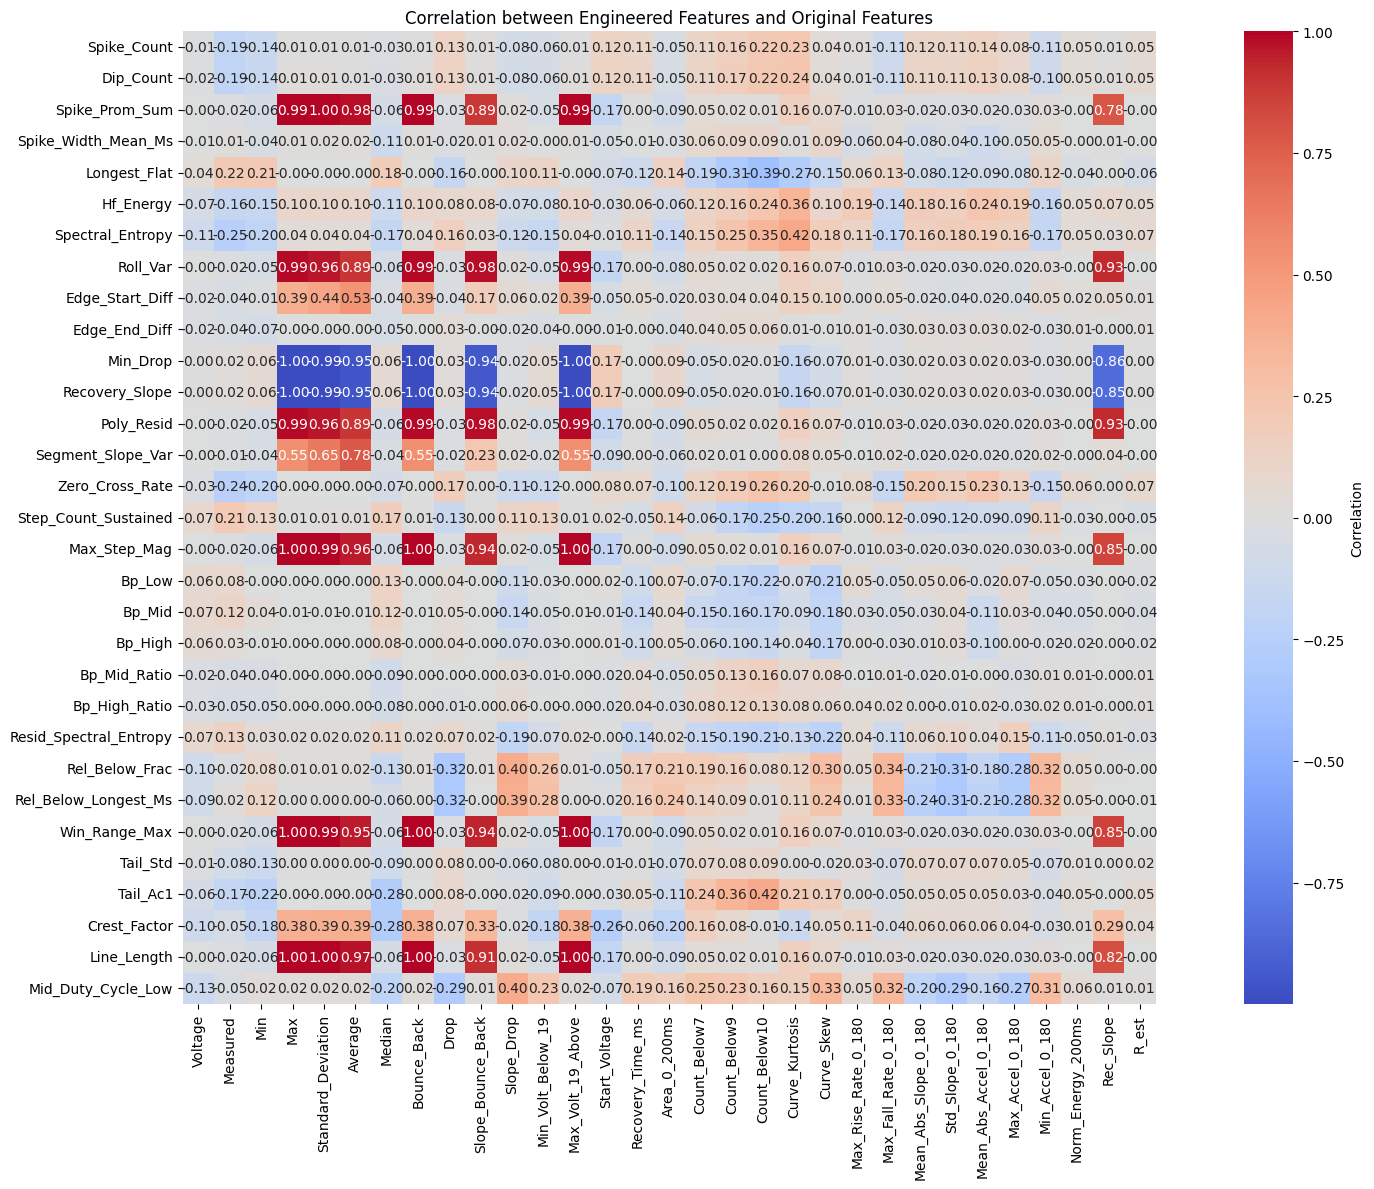

Top feature pairs with |correlation| > 0.5 (positive and negative):


,,Correlation
Max_Volt_19_Above,Win_Range_Max,1.000000
Max,Win_Range_Max,1.000000
Bounce_Back,Win_Range_Max,1.000000
Max_Volt_19_Above,Recovery_Slope,-1.000000
Bounce_Back,Recovery_Slope,-1.000000
Max,Recovery_Slope,-1.000000
Standard_Deviation,Spike_Prom_Sum,0.999993
Max_Volt_19_Above,Max_Step_Mag,0.999991
Max,Max_Step_Mag,0.999991
Bounce_Back,Max_Step_Mag,0.999991


features that greater than 0.8:
 ['Line_Length', 'Max_Step_Mag', 'Poly_Resid', 'Roll_Var', 'Spike_Prom_Sum', 'Win_Range_Max']


In [23]:
# Correlation analysis between engineered features and original features

engineered_features = [
   'Spike_Count', 'Dip_Count', 'Spike_Prom_Sum', 'Spike_Width_Mean_Ms',
    'Longest_Flat', 'Hf_Energy', 'Spectral_Entropy', 'Roll_Var',
    'Edge_Start_Diff', 'Edge_End_Diff', 'Min_Drop', 'Recovery_Slope',
    'Poly_Resid', 'Segment_Slope_Var', 'Zero_Cross_Rate',
    'Step_Count_Sustained', 'Max_Step_Mag', 'Bp_Low', 'Bp_Mid', 'Bp_High',
    'Bp_Mid_Ratio', 'Bp_High_Ratio', 'Resid_Spectral_Entropy',
    'Rel_Below_Frac', 'Rel_Below_Longest_Ms', 'Win_Range_Max',
    'Tail_Std', 'Tail_Ac1', 'Crest_Factor', 'Line_Length',
    'Mid_Duty_Cycle_Low'
 ]
original_features = [
    'Voltage','Measured','Min','Max','Standard_Deviation','Average','Median',
    'Bounce_Back','Drop','Slope_Bounce_Back','Slope_Drop','Min_Volt_Below_19','Max_Volt_19_Above','Start_Voltage','Recovery_Time_ms',
    'Area_0_200ms','Count_Below7','Count_Below9','Count_Below10','Curve_Kurtosis','Curve_Skew','Max_Rise_Rate_0_180','Max_Fall_Rate_0_180',
    'Mean_Abs_Slope_0_180','Std_Slope_0_180','Mean_Abs_Accel_0_180','Max_Accel_0_180','Min_Accel_0_180','Norm_Energy_200ms','Rec_Slope','R_est'
 ]
# Compute correlation matrix for engineered vs original features
corr = data[engineered_features + original_features].corr()
corr_sub = corr.loc[engineered_features, original_features]
# Plot heatmap in a box
plt.figure(figsize=(18, 12))
sns.heatmap(corr_sub, annot=True, square=True,cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'}, fmt='.2f')
plt.title('Correlation between Engineered Features and Original Features')
plt.tight_layout()
plt.show()
# Find and display the top correlated pairs (|correlation| > 0.5) including both positive and negative
corr_pairs_full = corr_sub.unstack().sort_values(key=lambda x: abs(x), ascending=False)
strong_corr = corr_pairs_full[(corr_pairs_full.abs() > 0.5)]
if not strong_corr.empty:
    print('Top feature pairs with |correlation| > 0.5 (positive and negative):')
    display(strong_corr.to_frame('Correlation'))
else:
    print('No feature pairs with |correlation| > 0.5 found.')
# Get pairs with correlation strictly greater than 0.8
corr_pairs_strong = corr_sub.unstack()
greater_08 = corr_pairs_strong[corr_pairs_strong > 0.8]

greater_08_list = [(idx[0], idx[1]) for idx, val in greater_08.items()]
# Extract just the 2nd variable (engineered feature names)
second_vars = [b for (_, b) in greater_08_list]
# If you only want unique values, sorted:
second_vars_unique = sorted(set(second_vars))
print('features that greater than 0.8:\n',second_vars_unique)

In [24]:
data.Battery_Decision.value_counts()

Battery_Decision
GOOD BATTERY    14390
BAD BATTERY      3352
Name: count, dtype: int64

In [25]:
label_encoder = LabelEncoder()

data.Battery_Decision = label_encoder.fit_transform(final_mvt_data.Battery_Decision.values)
data.Battery_Decision.value_counts()

Battery_Decision
1    14390
0     3352
Name: count, dtype: int64

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17742 entries, 0 to 18080
Data columns (total 66 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Test_Record_Detail_ID   17742 non-null  int64  
 1   Voltage                 17742 non-null  float64
 2   Rated                   17742 non-null  int64  
 3   Measured                17742 non-null  int64  
 4   Battery_Decision        17742 non-null  int64  
 5   Min                     17742 non-null  float64
 6   Max                     17742 non-null  float64
 7   Standard_Deviation      17742 non-null  float64
 8   Average                 17742 non-null  float64
 9   Median                  17742 non-null  float64
 10  Bounce_Back             17742 non-null  float64
 11  Drop                    17742 non-null  float64
 12  Slope_Bounce_Back       17742 non-null  float64
 13  Slope_Drop              17742 non-null  float64
 14  Min_Volt_Below_19       17742 non-null  flo

In [27]:
X_mvt=data.drop(columns=['Battery_Decision','Test_Record_Detail_ID','Rated','Line_Length', 'Max_Step_Mag', 'Poly_Resid', 'Roll_Var', 'Spike_Prom_Sum', 'Win_Range_Max'])
X_mvt.head()

y_mvt = data['Battery_Decision']  # Target variable: Battery decision (classification label)


In [28]:
X_mvt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17742 entries, 0 to 18080
Data columns (total 57 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Voltage                 17742 non-null  float64
 1   Measured                17742 non-null  int64  
 2   Min                     17742 non-null  float64
 3   Max                     17742 non-null  float64
 4   Standard_Deviation      17742 non-null  float64
 5   Average                 17742 non-null  float64
 6   Median                  17742 non-null  float64
 7   Bounce_Back             17742 non-null  float64
 8   Drop                    17742 non-null  float64
 9   Slope_Bounce_Back       17742 non-null  float64
 10  Slope_Drop              17742 non-null  float64
 11  Min_Volt_Below_19       17742 non-null  float64
 12  Max_Volt_19_Above       17742 non-null  float64
 13  Start_Voltage           17742 non-null  float64
 14  Time_To_Min_ms          17742 non-null  int

In [29]:
# Remove rows where y_mvt is NaN
mask = ~y_mvt.isna()
X_mvt = X_mvt[mask]
y_mvt = y_mvt[mask]

In [30]:
# Split the data into training, validation, and test sets
Xmvt_train, Xmvt_temp, ymvt_train, ymvt_temp = train_test_split(
    X_mvt, y_mvt, test_size=0.2, random_state=12, stratify=y_mvt)  # 80% train, 20% temp (stratified)
Xmvt_val, Xmvt_test, ymvt_val, ymvt_test = train_test_split(
    Xmvt_temp, ymvt_temp, test_size=0.5, random_state=12, stratify=ymvt_temp)  # 10% val, 10% test

In [31]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """Evaluate a model on train, validation, and test sets. Returns classification reports and log loss."""
    results = {}
    datasets = {
        "Train": (X_train, y_train),
        "Validation": (X_val, y_val),
        "Test": (X_test, y_test)
    }
    for name, (X, y) in datasets.items():
        y_pred = model.predict(X)
        report = classification_report(y, y_pred)
        results[name] = {"classification_report": report}
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X)
            results[name]["log_loss"] = log_loss(y, y_proba)
        else:
            results[name]["log_loss"] = None
    return results

def display_evaluation_metrics(results, cluster_name="Model Evaluation Results"):
    """Display evaluation results in a horizontally stacked layout for easy comparison."""
    html = f"""<h1 style='text-align:center;'>{cluster_name}</h1><div class='results-container'><style>.results-container {{display: flex;flex-direction: row;justify-content: space-around;flex-wrap: wrap;gap: 20px;}}.dataset-card {{border: 1px solid #ccc;border-radius: 5px;padding: 10px;box-shadow: 2px 2px 10px rgba(0, 0, 0, 0.3);width: 40%;min-width: 350px;overflow: auto;background: #fff;color: #333;}}.dataset-card h2 {{text-align: center;margin-top: 0;color: #222;}}.dataset-card h3 {{color: #444;margin-bottom: 5px;}}pre {{white-space: pre-wrap;background-color: #eaeaea;padding: 10px;border-radius: 3px;color: #000;}}p {{font-size: 12px;margin: 5px 0;font-weight: bold;}}</style>"""
    for dataset, metrics in results.items():
        log_loss_val = (f"{metrics['log_loss']:.4f}" if metrics["log_loss"] is not None else "N/A")
        card = f"""<div class='dataset-card'><h2>{dataset} Dataset</h2><h3>Classification Report</h3><pre>{metrics["classification_report"]}</pre><h3>Log Loss</h3><p>{log_loss_val}</p></div>"""
        html += card
    html += "</div>"
    display(HTML(html))

# XGB With KFold Cross Validation Base Model

In [32]:
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

oof_predictions = np.zeros(len(X_mvt))
all_fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_mvt, y_mvt)):
    print(f"Fold {fold + 1}")

    # Split
    X_train_fold, X_val_fold = X_mvt.iloc[train_idx], X_mvt.iloc[val_idx]
    y_train_fold, y_val_fold = y_mvt.iloc[train_idx], y_mvt.iloc[val_idx]

    # (No PCA / no augmentation)
    X_train_model = X_train_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_val_model   = X_val_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_test_model  = Xmvt_test.drop(columns=['Test_Record_Detail_ID'], errors='ignore')

    # Model
    xgb_mvt = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        seed=10,
        n_estimators=500,
        max_depth=4,
        early_stopping_rounds=5,
        n_jobs=-1,
        sampling_method='gradient_based',
        device='cuda',
        tree_method='hist'
    )

    # Fit with early stopping on validation fold
    xgb_mvt.fit(
        X_train_model.values, y_train_fold.values,
        eval_set=[(X_val_model.values, y_val_fold.values)],
        verbose=False
    )

    # OOF preds
    oof_predictions[val_idx] = xgb_mvt.predict_proba(X_val_model.values)[:, 1]

    # Evaluate (no PCA features passed)
    fold_results = evaluate_model(
        xgb_mvt,
        X_train_model, y_train_fold,
        X_val_model,   y_val_fold,
        X_test_model,  ymvt_test
    )
    all_fold_results.append(fold_results)

    display_evaluation_metrics(fold_results, cluster_name=f"Fold {fold + 1} Evaluation Results")

# Aggregates
avg_log_loss = np.mean([fold["Validation"]["log_loss"] for fold in all_fold_results if fold["Validation"]["log_loss"] is not None])
print(f"Average Validation Log Loss Across Folds: {avg_log_loss}")
print("Out-of-Fold Log Loss:", log_loss(y_mvt, oof_predictions))


Fold 1


Fold 2


Fold 3


Fold 4


Fold 5


Average Validation Log Loss Across Folds: 0.17305477301789868
Out-of-Fold Log Loss: 0.1730546387645976


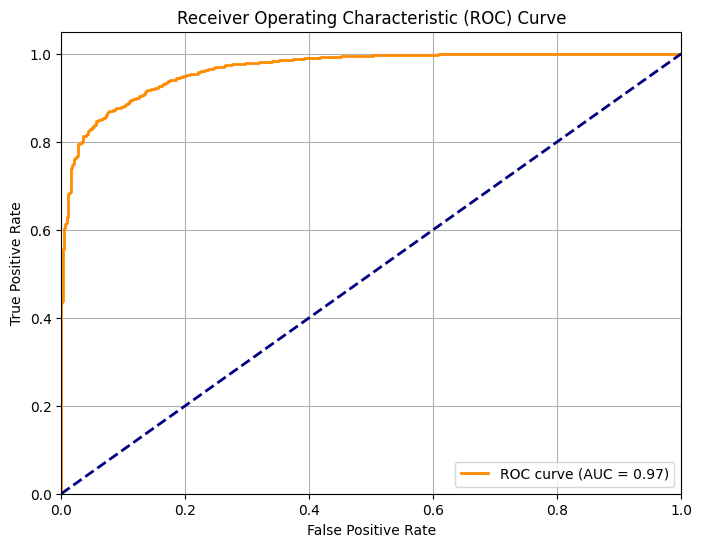

In [33]:
# ROC Curve and AUC for the final Optuna-tuned model
#  Use  validation set predictions and true labels
# Replace y_true and y_proba with your actual variables
y_true = y_val_fold  # or y_test, etc.
y_proba = xgb_mvt.predict_proba(X_val_fold.values)[:, 1]  # or X_test, etc.

fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [34]:
# Summarize metrics for each fold and show averages efficiently
def extract_accuracy(report):
    for line in report.split('\n'):
        if 'accuracy' in line:
            try:
                return float(line.split()[1])
            except Exception:
                return None
    return None

fold_metrics = []
for i, fold in enumerate(all_fold_results):
    train_acc = extract_accuracy(fold['Train']['classification_report'])
    val_acc = extract_accuracy(fold['Validation']['classification_report'])
    test_acc = extract_accuracy(fold['Test']['classification_report'])
    fold_metrics.append({
        'Fold': i + 1,
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Test Accuracy': test_acc,
        'Train Log Loss': fold['Train']['log_loss'],
        'Validation Log Loss': fold['Validation']['log_loss'],
        'Test Log Loss': fold['Test']['log_loss']
    })
metrics_df = pd.DataFrame(fold_metrics)
avg_metrics = metrics_df.mean(numeric_only=True)
avg_metrics['Fold'] = 'Average'
metrics_df = pd.concat([metrics_df, pd.DataFrame([avg_metrics])], ignore_index=True)


## Metric results

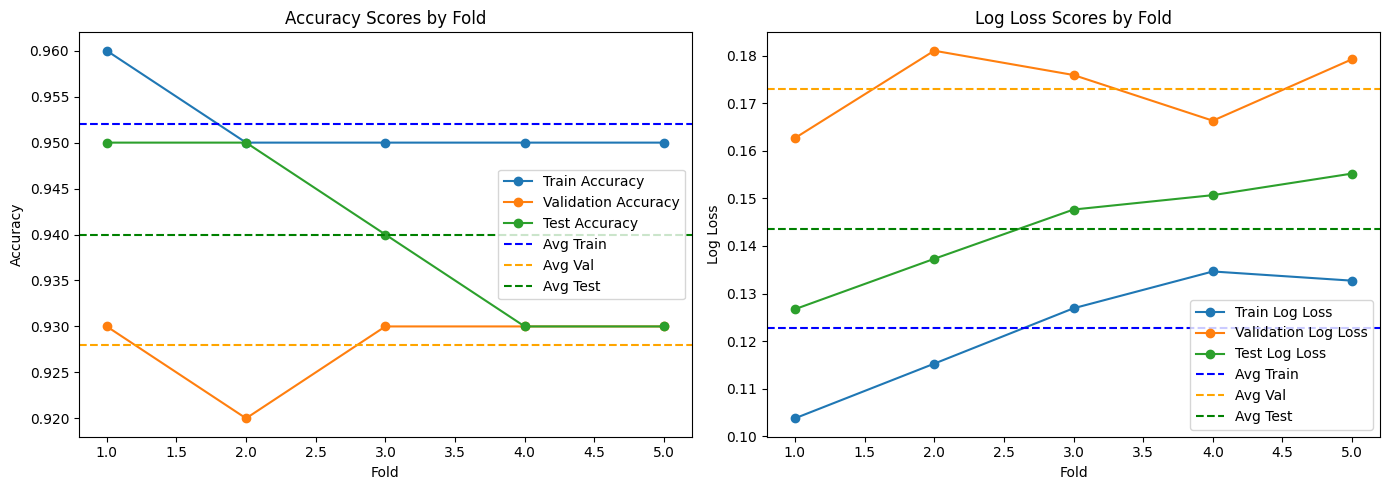

,Fold,Train Accuracy,Validation Accuracy,Test Accuracy,Train Log Loss,Validation Log Loss,Test Log Loss
0,1,0.960,0.930,0.95,0.103772,0.162678,0.126713
1,2,0.950,0.920,0.95,0.115266,0.181049,0.137301
2,3,0.950,0.930,0.94,0.126907,0.175944,0.147661
3,4,0.950,0.930,0.93,0.134645,0.166339,0.150689
4,5,0.950,0.930,0.93,0.132711,0.179264,0.155226
5,Average,0.952,0.928,0.94,0.122660,0.173055,0.143518


In [35]:
import matplotlib.pyplot as plt
fold_rows = metrics_df[metrics_df['Fold'] != 'Average']
avg_row = metrics_df[metrics_df['Fold'] == 'Average']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(fold_rows['Fold'], fold_rows['Train Accuracy'], marker='o', label='Train Accuracy')
axes[0].plot(fold_rows['Fold'], fold_rows['Validation Accuracy'], marker='o', label='Validation Accuracy')
axes[0].plot(fold_rows['Fold'], fold_rows['Test Accuracy'], marker='o', label='Test Accuracy')
axes[0].axhline(avg_row['Train Accuracy'].values[0], color='blue', linestyle='--', label='Avg Train')
axes[0].axhline(avg_row['Validation Accuracy'].values[0], color='orange', linestyle='--', label='Avg Val')
axes[0].axhline(avg_row['Test Accuracy'].values[0], color='green', linestyle='--', label='Avg Test')
axes[0].set_title('Accuracy Scores by Fold')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[1].plot(fold_rows['Fold'], fold_rows['Train Log Loss'], marker='o', label='Train Log Loss')
axes[1].plot(fold_rows['Fold'], fold_rows['Validation Log Loss'], marker='o', label='Validation Log Loss')
axes[1].plot(fold_rows['Fold'], fold_rows['Test Log Loss'], marker='o', label='Test Log Loss')
axes[1].axhline(avg_row['Train Log Loss'].values[0], color='blue', linestyle='--', label='Avg Train')
axes[1].axhline(avg_row['Validation Log Loss'].values[0], color='orange', linestyle='--', label='Avg Val')
axes[1].axhline(avg_row['Test Log Loss'].values[0], color='green', linestyle='--', label='Avg Test')
axes[1].set_title('Log Loss Scores by Fold')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Log Loss')
axes[1].legend()
plt.tight_layout()
plt.show()
display(metrics_df)


In [36]:
def plot_xgb_top15_importances(best_xgb_mvt, feature_names, top_n=15):
    """
    Plot top-N XGBoost feature importances for gain, weight, and cover,
    mapping fN -> your training feature names (order matters).
    Shows a table with the numeric values *under each plot*.
    """
    booster = best_xgb_mvt.get_booster()
    importance_types = ['gain', 'weight', 'cover']

    # Infer how many features the model has (from fN keys across all types)
    all_keys = set()
    for imp_type in importance_types:
        all_keys |= set(booster.get_score(importance_type=imp_type).keys())
    n_from_model = (max(int(k[1:]) for k in all_keys if k.startswith('f')) + 1) if all_keys else len(feature_names)

    if len(feature_names) != n_from_model:
        print(f"[WARN] feature_names length ({len(feature_names)}) != model feature count ({n_from_model}). "
              f"Mapping up to min length.")
    max_len = min(len(feature_names), n_from_model)
    fmap = {f"f{i}": feature_names[i] for i in range(max_len)}

    for imp_type in importance_types:
        raw = booster.get_score(importance_type=imp_type)  # {'f0': val, 'f12': val, ...}
        mapped = {fmap[k]: v for k, v in raw.items() if k in fmap}
        if not mapped:
            print(f"[INFO] No entries for importance_type={imp_type}. Skipping.")
            continue

        s = pd.Series(mapped).sort_values(ascending=False).head(top_n)

        # --- Plot ---
        fig, ax = plt.subplots(figsize=(10, 0.5 * len(s) + 1.5))
        y = np.arange(len(s))
        ax.barh(y, s.values)
        ax.set_yticks(y)
        ax.set_yticklabels(s.index)
        ax.invert_yaxis()
        ax.set_title(f"Top {top_n} Feature Importance ({imp_type})")
        ax.set_xlabel(imp_type)

        # Label values at end of bars (remove these two lines if you only want numbers in the table)
        for i, v in enumerate(s.values):
            label = f"{int(v)}" if imp_type == 'weight' else f"{v:.3f}"
            ax.text(v, i, f" {label}", va='center', ha='left')

        # --- Table under the plot with the numbers ---
        table_rows = []
        for name, val in zip(s.index, s.values):
            label = f"{int(val)}" if imp_type == 'weight' else f"{val:.6g}"
            table_rows.append([name, label])

        # Position table below; tweak bbox/bottom margin if needed
        tbl = plt.table(cellText=table_rows,
                        colLabels=['Feature', imp_type],
                        loc='bottom', cellLoc='left',
                        bbox=[0.0, -0.58, 1.0, 0.55])  # [x0, y0, width, height]

        # Make space for the table and long ytick labels
        plt.subplots_adjust(left=0.35, bottom=0.35)
        plt.tight_layout()
        plt.show()

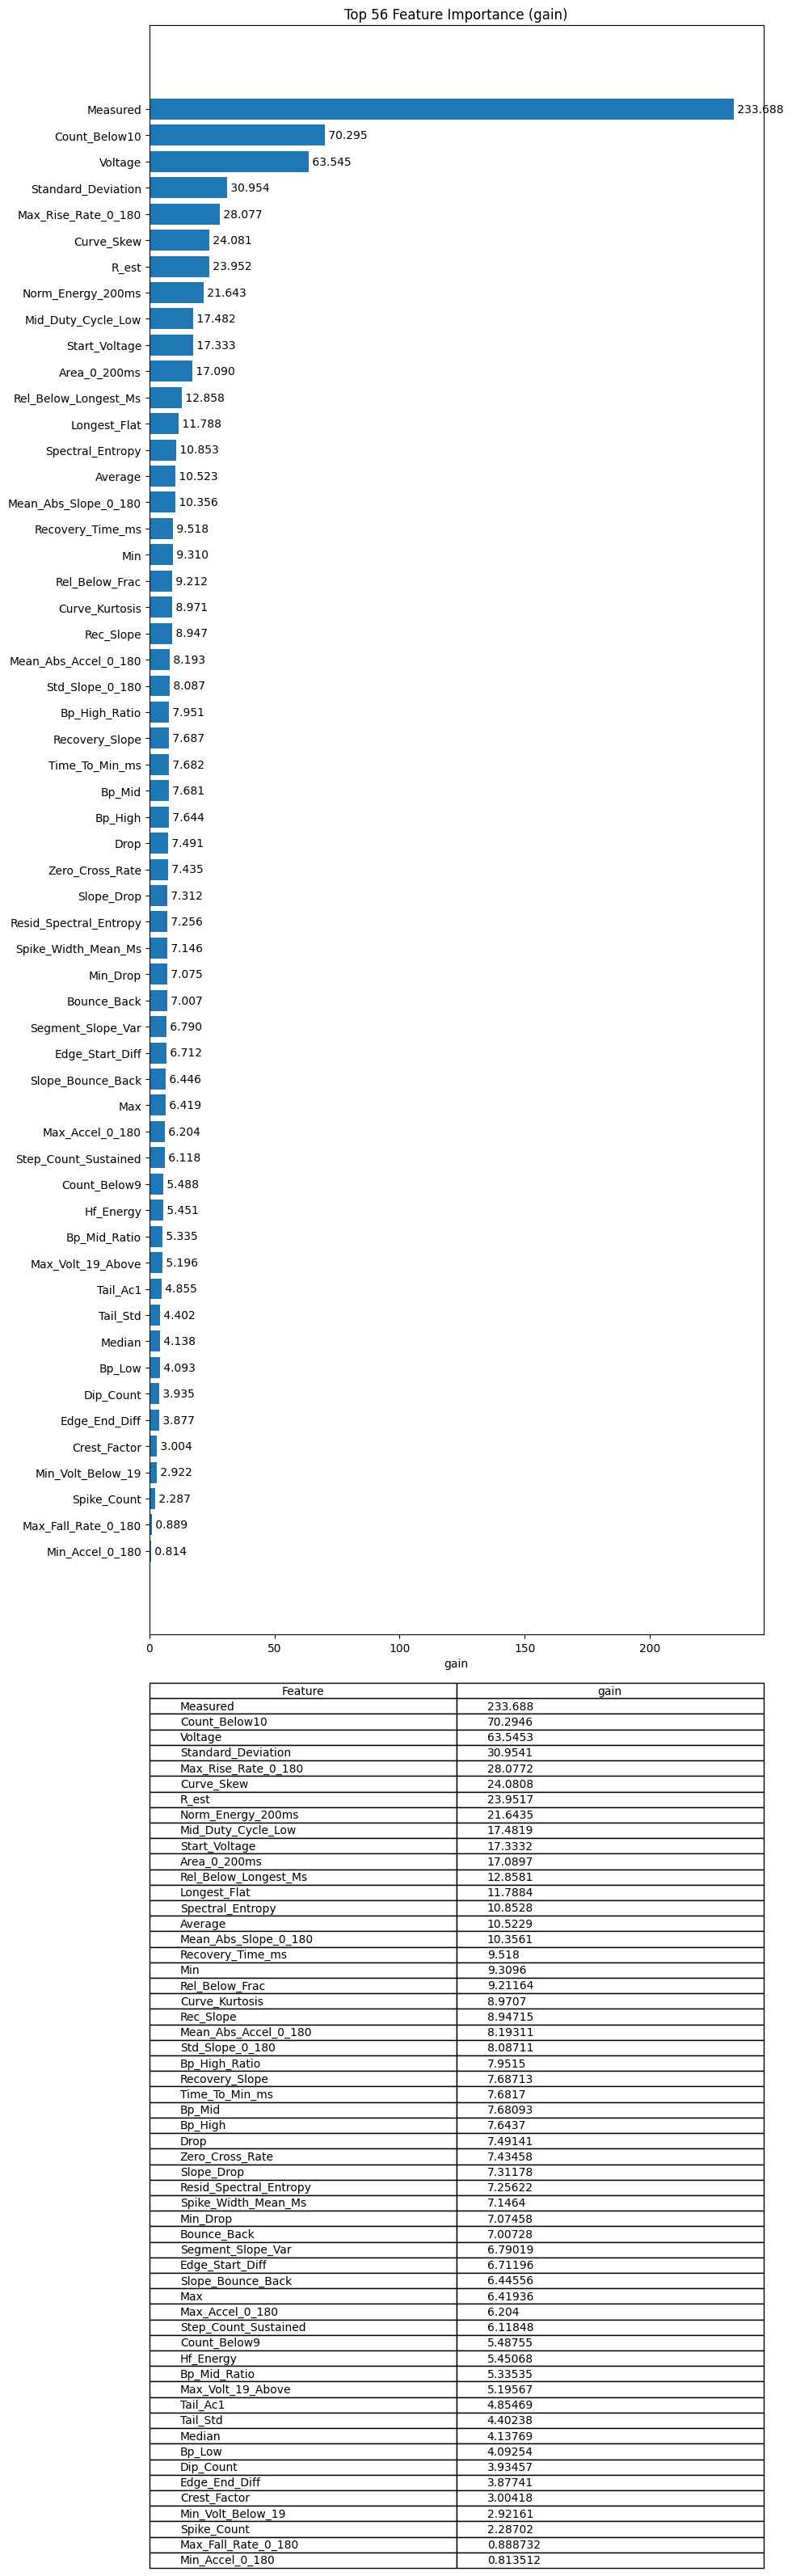

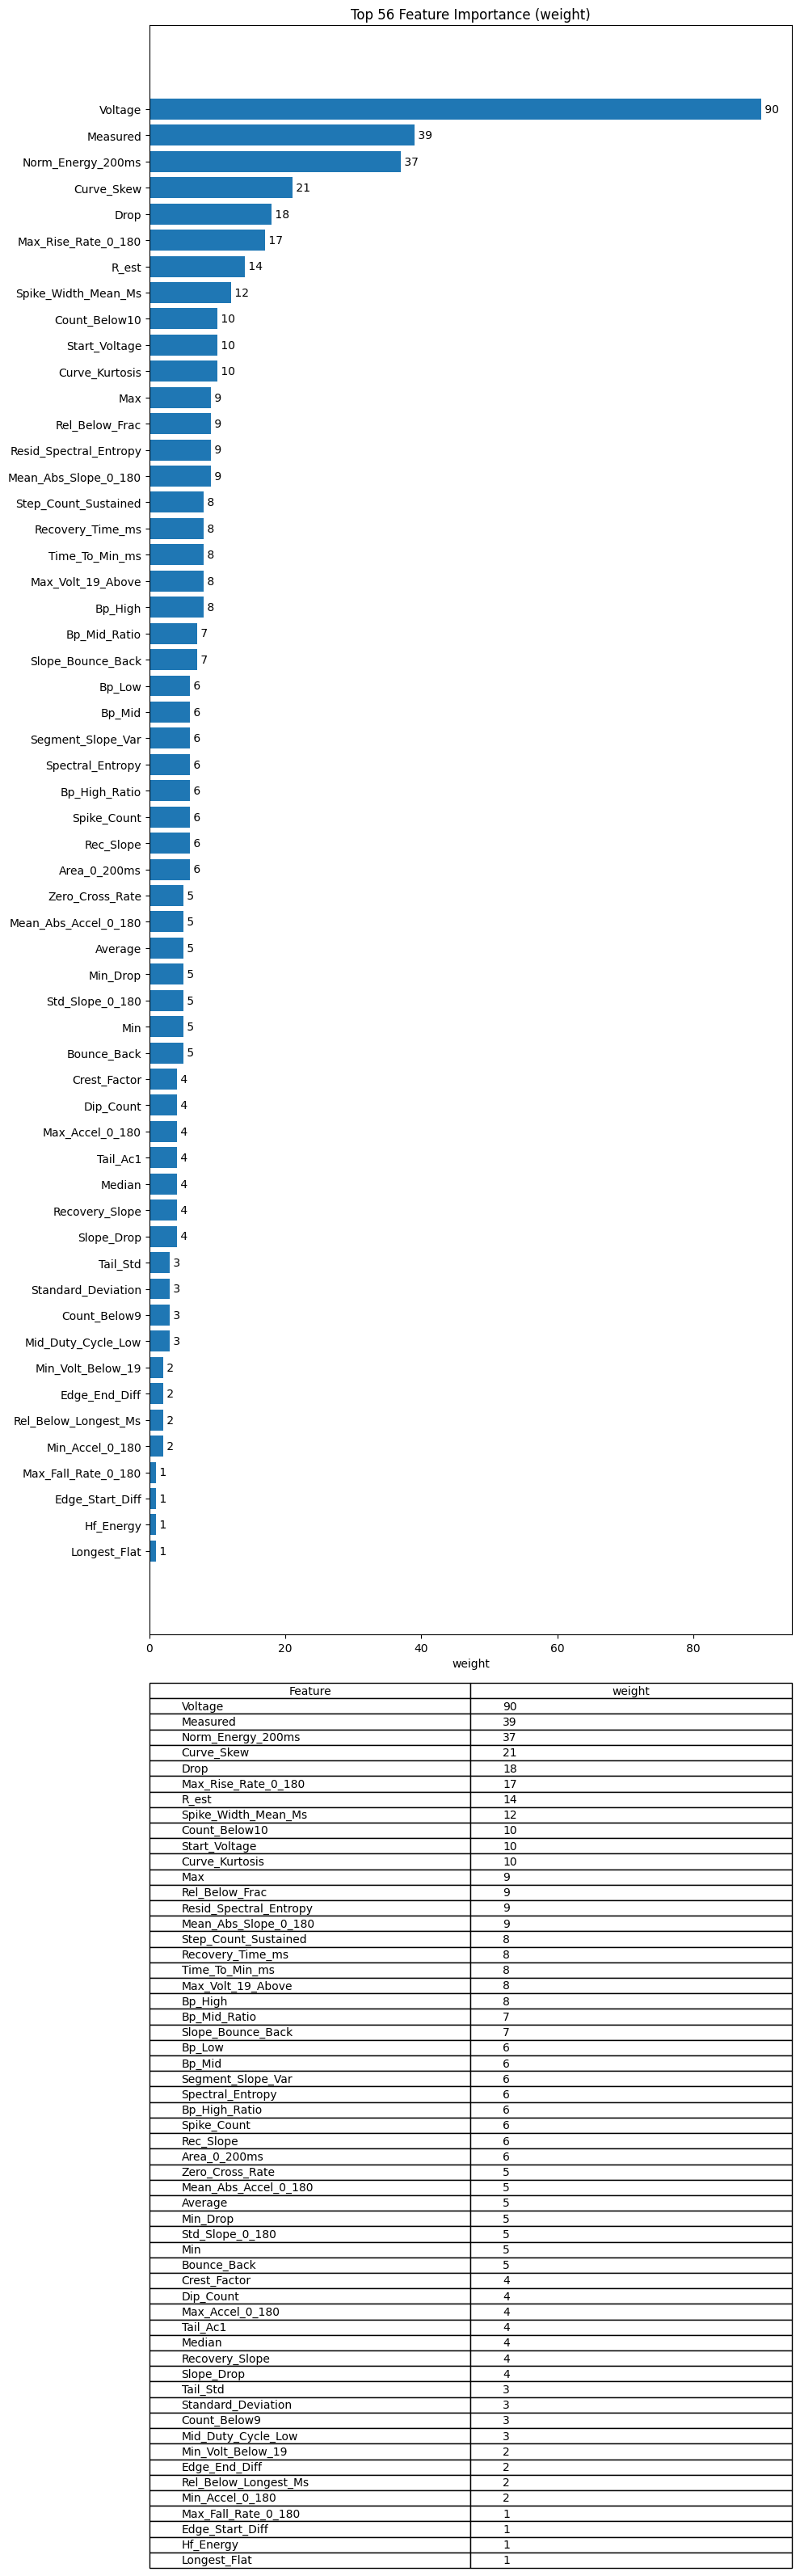

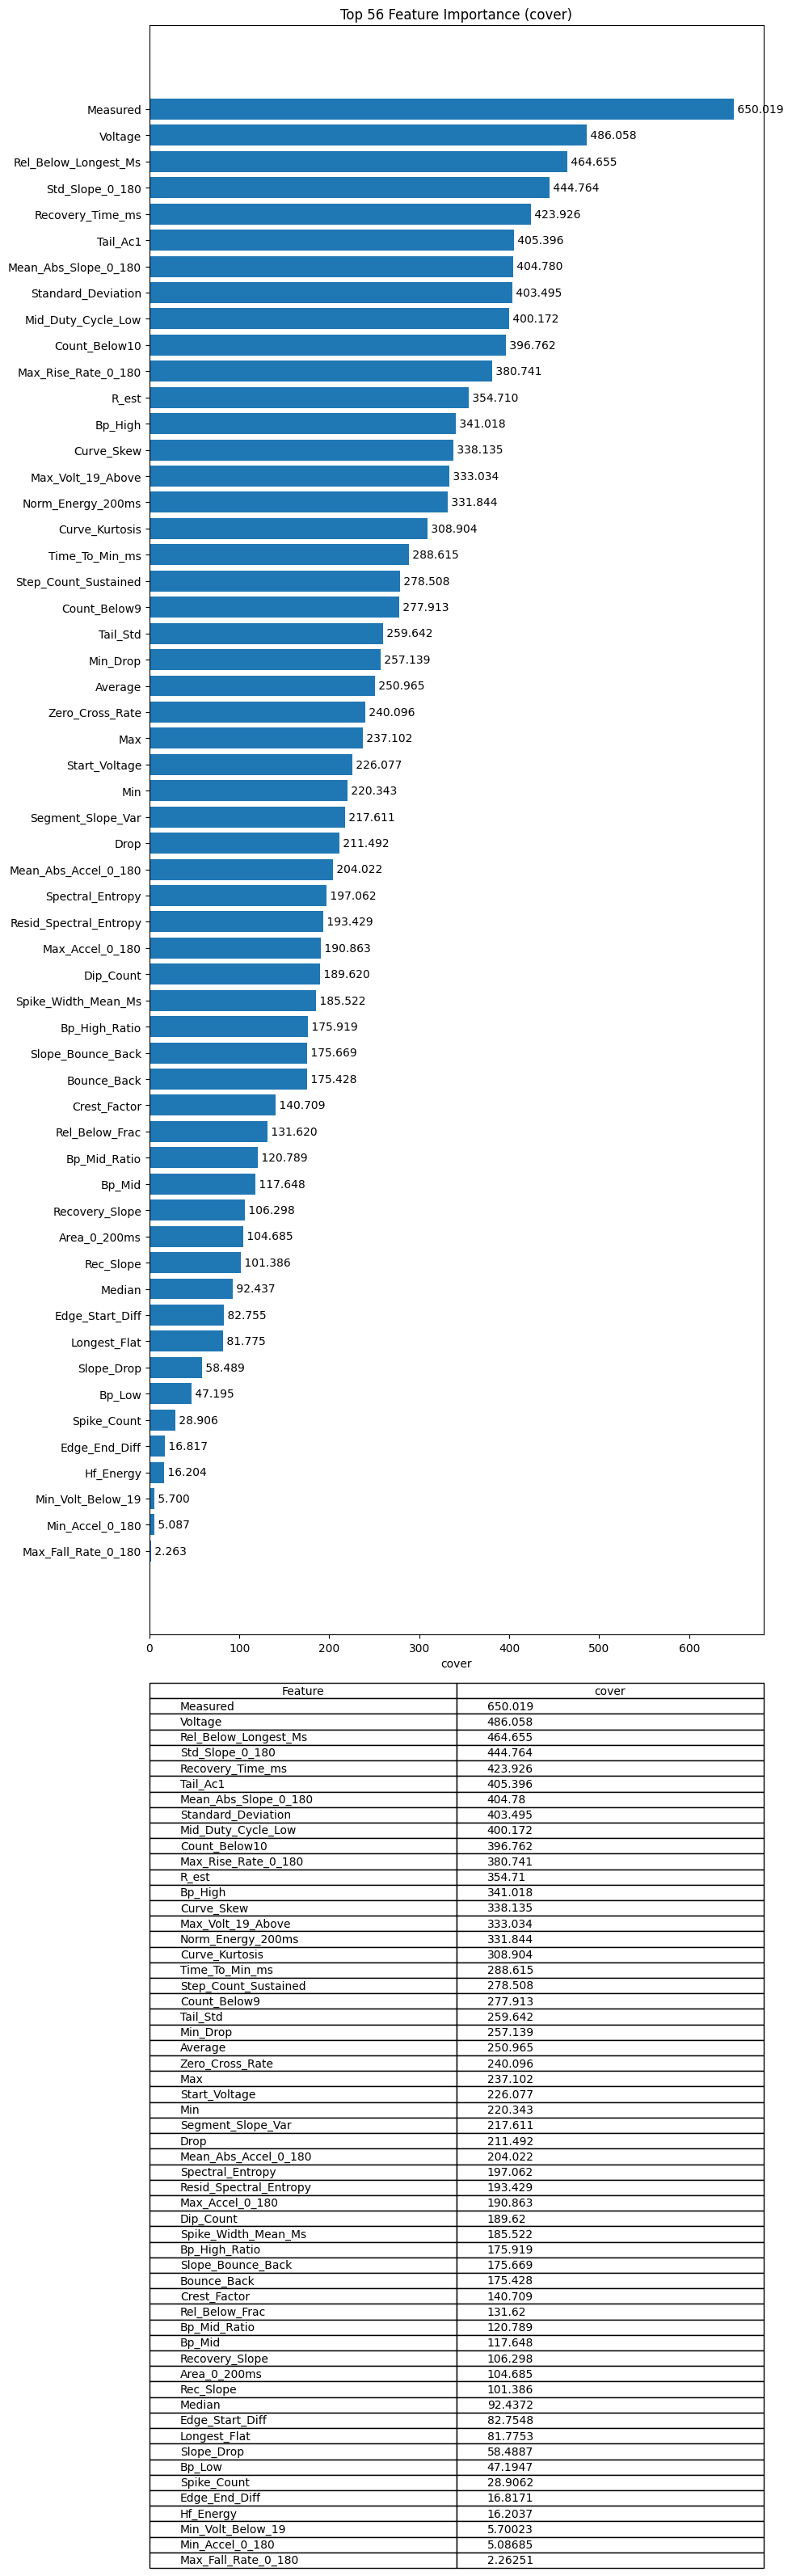

In [37]:
# Use the exact feature names & order from training:
feature_names = list(X_train_model.columns)

plot_xgb_top15_importances(xgb_mvt, feature_names, top_n=56)

## Apply SHAP for evaluate important features. 

In [38]:
# === SHAP-driven feature pruning for XGBoost (no CSV when ≤56 features) ===
def shap_feature_pruning(
    xgb_model,
    X_val,
    y_val=None,
    *,
    id_cols=("Test_Record_Detail_ID",),
    sample_rows=None,
    importance_cutoff_pct=0.3,   # drop features contributing < this % of total mean|SHAP|
    keep_top_k=None,             # if set (int), overrides the pct rule and keeps only top-k
    model_output="probability",
    top_n_plot=30,
    save_csv_path=None,          # default: don't save
    show_full_table_if_n_le=56   # print full ranking if feature count <= this
):
    """
    Compute SHAP values for an XGBoost model, visualize global importance,
    and suggest low-importance features to drop. Prints full table if features <= show_full_table_if_n_le.
    """
    # 1) Clean X
    X = X_val.copy()
    for c in (id_cols or []):
        if c in X.columns:
            X = X.drop(columns=[c])

    # Optional speed-up
    if sample_rows is not None and len(X) > sample_rows:
        X = X.sample(sample_rows, random_state=42)
        if y_val is not None and hasattr(y_val, "loc"):
            y_val = y_val.loc[X.index]

    # 2) Explainer
    try:
        explainer = shap.TreeExplainer(xgb_model, data=X, model_output=model_output)
    except Exception:
        explainer = shap.Explainer(xgb_model, X, algorithm="tree")

    # 3) SHAP values
    shap_exp = explainer(X)

    # 4) Global beeswarm
    shap.plots.beeswarm(shap_exp, show=False)
    plt.title("SHAP Feature Importance — Global (ranked by mean |SHAP|)", pad=16)
    plt.tight_layout()
    plt.show()

    # 5) Numeric importance
    shap_values = shap_exp.values if hasattr(shap_exp, "values") else np.array(shap_exp)
    if shap_values.ndim == 3:
        shap_values = np.mean(np.abs(shap_values), axis=2)
    mean_abs = np.mean(np.abs(shap_values), axis=0)
    total = mean_abs.sum() if mean_abs.sum() > 0 else 1.0
    pct = (mean_abs / total) * 100.0

    feature_importance_df = (
        pd.DataFrame({"feature": X.columns, "mean_abs_shap": mean_abs, "pct_of_total": pct})
        .sort_values("mean_abs_shap", ascending=False)
        .reset_index(drop=True)
    )
    feature_importance_df["rank"] = np.arange(1, len(feature_importance_df) + 1)

    # 6) Bar plot (top-N)
    k = min(top_n_plot, len(feature_importance_df))
    top_bar = feature_importance_df.head(k)
    fig, ax = plt.subplots(figsize=(10, 0.5 * len(top_bar) + 1.5))
    y = np.arange(len(top_bar))
    ax.barh(y, top_bar["mean_abs_shap"].values)
    ax.set_yticks(y)
    ax.set_yticklabels(top_bar["feature"].values)
    ax.invert_yaxis()
    ax.set_title(f"Top {len(top_bar)} Features by Mean |SHAP|")
    ax.set_xlabel("Mean |SHAP| (global importance)")

    for i, (v_abs, v_pct) in enumerate(zip(top_bar["mean_abs_shap"].values, top_bar["pct_of_total"].values)):
        ax.text(v_abs, i, f"  {v_abs:.4g}  ({v_pct:.2f}%)", va="center", ha="left")
    plt.tight_layout()
    plt.show()

    # 7) Prune rule
    if keep_top_k is not None:
        to_drop = feature_importance_df.iloc[keep_top_k:]["feature"].tolist()
        rule_used = f"keep_top_k={keep_top_k}"
    else:
        cutoff = importance_cutoff_pct
        to_drop = feature_importance_df.loc[feature_importance_df["pct_of_total"] < cutoff, "feature"].tolist()
        rule_used = f"pct_of_total < {cutoff:.3g}%"

    # 8) Show results (print full table if small)
    nfeat = len(feature_importance_df)
    print("=== SHAP Feature Importance (mean |SHAP|) ===")
    if nfeat <= show_full_table_if_n_le:
        # Show everything for small models (like your 56 features)
        print(feature_importance_df.to_string(index=False, float_format=lambda x: f"{x:.6g}"))
    else:
        print(feature_importance_df.head(20).to_string(index=False, float_format=lambda x: f"{x:.6g}"))
        print(f"... ({nfeat-20} more features)")

    if save_csv_path and nfeat > show_full_table_if_n_le:
        # Only save if explicitly requested AND there are lots of features
        feature_importance_df.to_csv(save_csv_path, index=False)

    print(f"\nRule used for pruning: {rule_used}")
    print(f"Suggested features to drop (n={len(to_drop)}):")
    print(to_drop)

    return feature_importance_df, to_drop


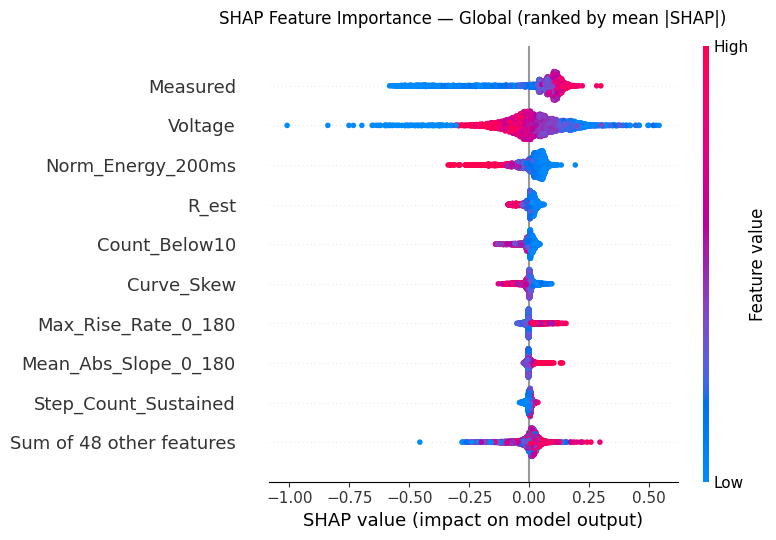

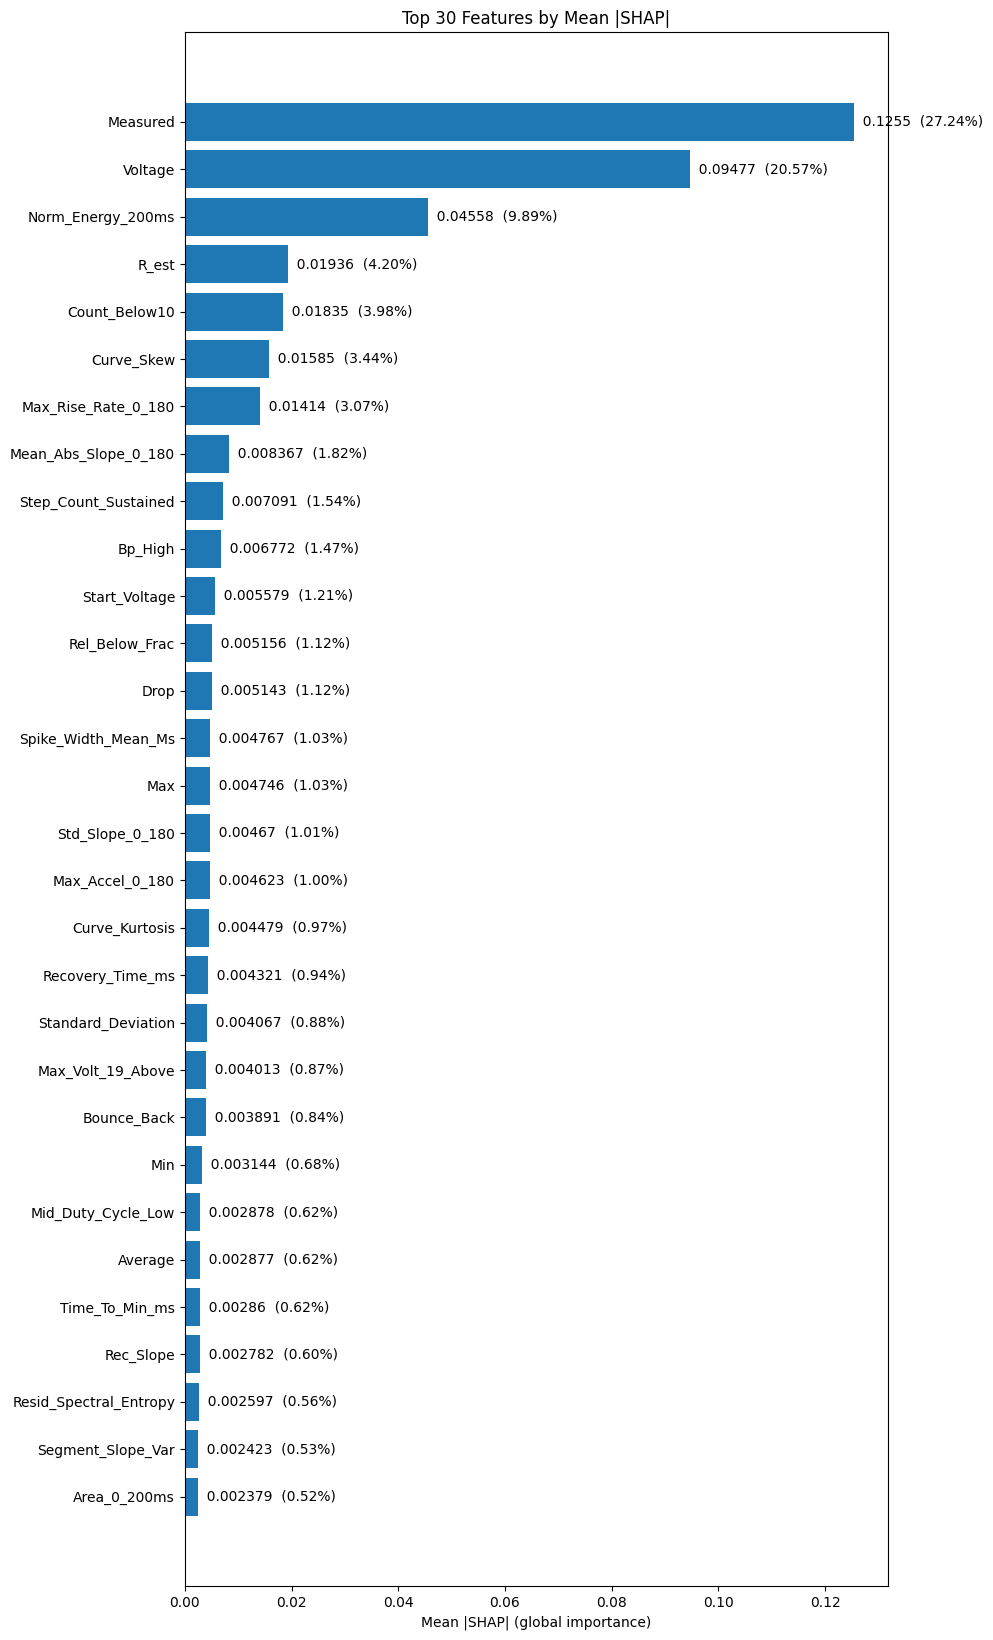

=== SHAP Feature Importance (mean |SHAP|) ===
             feature  mean_abs_shap  pct_of_total  rank
            Measured       0.125485       27.2368     1
             Voltage      0.0947682       20.5697     2
   Norm_Energy_200ms       0.045584       9.89415     3
               R_est      0.0193554       4.20116     4
       Count_Below10      0.0183529       3.98355     5
          Curve_Skew      0.0158521       3.44075     6
 Max_Rise_Rate_0_180       0.014141       3.06934     7
Mean_Abs_Slope_0_180     0.00836748       1.81619     8
Step_Count_Sustained     0.00709126       1.53918     9
             Bp_High     0.00677195       1.46987    10
       Start_Voltage     0.00557945       1.21104    11
      Rel_Below_Frac     0.00515648       1.11923    12
                Drop     0.00514278       1.11626    13
 Spike_Width_Mean_Ms     0.00476662       1.03461    14
                 Max     0.00474649       1.03024    15
     Std_Slope_0_180     0.00466978       1.01359    16
  

In [39]:
fi_df, drop_list = shap_feature_pruning(
    xgb_model=xgb_mvt,
    X_val=X_val_fold,
    y_val=y_val_fold,
    id_cols=("Test_Record_Detail_ID",),
    sample_rows=None,
    importance_cutoff_pct=0.3,  # drop <0.3% total mean|SHAP|
    keep_top_k=None,
    model_output="probability",
    top_n_plot=30,
    save_csv_path=None,         
    show_full_table_if_n_le=56  # <-- prints full table for 56 features
)

In [40]:
X_mvt=data.drop(columns=['Battery_Decision','Test_Record_Detail_ID','Rated','Line_Length', 'Max_Step_Mag', 'Poly_Resid', 'Roll_Var', 'Spike_Prom_Sum', 'Win_Range_Max','Crest_Factor', 'Count_Below9', 'Tail_Std', 'Recovery_Slope', 'Dip_Count', 'Edge_End_Diff', 'Longest_Flat', 'Edge_Start_Diff', 'Count_Below7'])


y_mvt = data['Battery_Decision']  # Target variable: Battery decision (classification label)


display(X_mvt.head())
display(X_mvt.info())


,Voltage,Measured,Min,Max,Standard_Deviation,Average,Median,Bounce_Back,Drop,Slope_Bounce_Back,Slope_Drop,Min_Volt_Below_19,Max_Volt_19_Above,Start_Voltage,Time_To_Min_ms,Recovery_Time_ms,Area_0_200ms,Count_Below10,Curve_Kurtosis,Curve_Skew,Max_Rise_Rate_0_180,Max_Fall_Rate_0_180,Mean_Abs_Slope_0_180,Std_Slope_0_180,Mean_Abs_Accel_0_180,Max_Accel_0_180,Min_Accel_0_180,Norm_Energy_200ms,Rec_Slope,R_est,Spike_Count,Spike_Width_Mean_Ms,Hf_Energy,Spectral_Entropy,Min_Drop,Segment_Slope_Var,Zero_Cross_Rate,Step_Count_Sustained,Bp_Low,Bp_Mid,Bp_High,Bp_Mid_Ratio,Bp_High_Ratio,Resid_Spectral_Entropy,Rel_Below_Frac,Rel_Below_Longest_Ms,Tail_Ac1,Mid_Duty_Cycle_Low
0,12.84,645,8.39,12.93,0.669658,11.689461,11.780,3.95,4.54,0.034956,-0.756667,8.39,12.34,12.930,60,20.0,2225.4,4,7.592125,-1.428772,0.83,-4.54,0.405000,1.026002,0.658333,4.98,-4.54,3.450233,0.19750,0.084465,39,47.862152,0.623205,4.757934,-4.54,0.000402,0.209581,10,0.052201,0.244060,0.371963,4.675354,7.125538,4.102983,0.065868,70.0,0.180351,0.03
1,12.46,922,9.78,12.45,0.478886,11.077754,11.015,2.21,2.67,0.017540,-0.445000,9.78,11.99,12.450,60,40.0,2210.0,2,4.983360,0.878271,0.16,-2.67,0.207222,0.599452,0.325556,2.81,-2.67,2.396963,0.05525,0.034751,26,40.674908,0.589737,4.300860,-11.99,0.014496,0.179641,11,0.050355,0.212250,0.277153,4.215060,5.503966,4.102649,0.269461,290.0,0.000000,0.08
2,11.98,46,2.06,12.09,3.741225,4.674910,2.360,8.03,8.98,0.034170,-0.690769,3.11,11.14,12.088,130,40.0,1485.0,289,2.215625,1.056479,0.77,-5.92,0.645000,1.364683,1.194444,6.00,-5.83,32.282609,0.20075,2.342609,38,53.674177,0.583430,4.299583,-5.92,0.035570,0.251497,30,0.006746,0.019106,0.053971,2.831970,7.999902,3.897906,0.766467,970.0,0.802341,0.72
3,12.80,219,8.49,12.79,0.700432,11.213054,11.220,4.21,4.30,0.024620,-0.716667,8.49,12.70,12.788,60,20.0,2116.6,12,5.251126,-0.696963,0.94,-4.30,0.397778,0.974985,0.711667,4.45,-4.30,9.664840,0.21050,0.235616,50,22.750598,0.615616,4.720606,-4.30,0.000497,0.425150,11,0.059284,0.154160,0.384934,2.600383,6.493094,3.995298,0.041916,50.0,0.388092,0.00
6,11.99,443,8.02,12.01,0.954229,10.446587,10.250,3.43,3.99,0.034646,-0.570000,8.02,11.45,12.002,70,40.0,1946.5,61,2.077246,-0.297062,0.22,-2.73,0.286667,0.653826,0.333333,1.48,-2.73,4.393905,0.08575,0.108081,47,33.624184,0.559858,4.275312,-2.73,0.001463,0.251497,21,0.040500,0.119802,0.199820,2.958066,4.933818,3.793426,0.059880,80.0,-0.046076,0.02


<class 'pandas.core.frame.DataFrame'>
Index: 17742 entries, 0 to 18080
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Voltage                 17742 non-null  float64
 1   Measured                17742 non-null  int64  
 2   Min                     17742 non-null  float64
 3   Max                     17742 non-null  float64
 4   Standard_Deviation      17742 non-null  float64
 5   Average                 17742 non-null  float64
 6   Median                  17742 non-null  float64
 7   Bounce_Back             17742 non-null  float64
 8   Drop                    17742 non-null  float64
 9   Slope_Bounce_Back       17742 non-null  float64
 10  Slope_Drop              17742 non-null  float64
 11  Min_Volt_Below_19       17742 non-null  float64
 12  Max_Volt_19_Above       17742 non-null  float64
 13  Start_Voltage           17742 non-null  float64
 14  Time_To_Min_ms          17742 non-null  int

None

In [41]:
# Remove rows where y_mvt is NaN
mask = ~y_mvt.isna()
X_mvt = X_mvt[mask]
y_mvt = y_mvt[mask]

In [42]:
# Split the data into training, validation, and test sets
Xmvt_train, Xmvt_temp, ymvt_train, ymvt_temp = train_test_split(
    X_mvt, y_mvt, test_size=0.2, random_state=42, stratify=y_mvt)  # 80% train, 20% temp (stratified)
Xmvt_val, Xmvt_test, ymvt_val, ymvt_test = train_test_split(
    Xmvt_temp, ymvt_temp, test_size=0.5, random_state=42, stratify=ymvt_temp)  # 10% val, 10% test

# XGB Drop the features that Sharp metric is less than 1% 

In [43]:
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

oof_predictions = np.zeros(len(X_mvt))
all_fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_mvt, y_mvt)):
    print(f"Fold {fold + 1}")

    # Split
    X_train_fold, X_val_fold = X_mvt.iloc[train_idx], X_mvt.iloc[val_idx]
    y_train_fold, y_val_fold = y_mvt.iloc[train_idx], y_mvt.iloc[val_idx]

    # (No PCA / no augmentation)
    X_train_model = X_train_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_val_model   = X_val_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_test_model  = Xmvt_test.drop(columns=['Test_Record_Detail_ID'], errors='ignore')

    # Model
    xgb_mvt = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        seed=10,
        n_estimators=500,
        max_depth=4,
        early_stopping_rounds=5,
        n_jobs=-1,
        sampling_method='gradient_based',
        device='cuda',
        tree_method='hist'
    )

    # Fit with early stopping on validation fold
    xgb_mvt.fit(
        X_train_model.values, y_train_fold.values,
        eval_set=[(X_val_model.values, y_val_fold.values)],
        verbose=False
    )

    # OOF preds
    oof_predictions[val_idx] = xgb_mvt.predict_proba(X_val_model.values)[:, 1]

    # Evaluate (no PCA features passed)
    fold_results = evaluate_model(
        xgb_mvt,
        X_train_model, y_train_fold,
        X_val_model,   y_val_fold,
        X_test_model,  ymvt_test
    )
    all_fold_results.append(fold_results)

    display_evaluation_metrics(fold_results, cluster_name=f"Fold {fold + 1} Evaluation Results")

# Aggregates
avg_log_loss = np.mean([fold["Validation"]["log_loss"] for fold in all_fold_results if fold["Validation"]["log_loss"] is not None])
print(f"Average Validation Log Loss Across Folds: {avg_log_loss}")
print("Out-of-Fold Log Loss:", log_loss(y_mvt, oof_predictions))


Fold 1


Fold 2


Fold 3


Fold 4


Fold 5


Average Validation Log Loss Across Folds: 0.17137949480224196
Out-of-Fold Log Loss: 0.17137965539721173


# Adjust scale scale_pos_weight

In [44]:
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

oof_predictions = np.zeros(len(X_mvt))
all_fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_mvt, y_mvt)):
    print(f"Fold {fold + 1}")

    # Split
    X_train_fold, X_val_fold = X_mvt.iloc[train_idx], X_mvt.iloc[val_idx]
    y_train_fold, y_val_fold = y_mvt.iloc[train_idx], y_mvt.iloc[val_idx]

    # (No PCA / no augmentation)
    X_train_model = X_train_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_val_model   = X_val_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_test_model  = Xmvt_test.drop(columns=['Test_Record_Detail_ID'], errors='ignore')

     # ---- per-fold class weight (pos = 1) ----
    neg = int((y_train_fold == 0).sum())
    pos = int((y_train_fold == 1).sum())
    scale_pos_weight = neg / max(pos, 0)  # >1 if class 1 is minority

    best_compromise =  {'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.4910429253932203,
 'colsample_bylevel': 0.9521081666403901,
 'colsample_bynode': 0.9502389233223183,
 'colsample_bytree': 0.9410369777828046,
 'early_stopping_rounds': 100,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'gamma': 4.151682147783409,
 'grow_policy': 'depthwise',
 'max_delta_step': 0,
 'max_depth': 4,
 'max_leaves': 0,
 'min_child_weight': 1,
 'n_estimators': 500,
 'n_jobs': -1,
 'reg_alpha': 0,
 'reg_lambda': 2,
 'sampling_method': 'uniform',
 'scale_pos_weight': 0.27,
 'subsample': 0.7887050055975044,
 'tree_method': 'hist',
 'validate_parameters': 1,
 'verbosity': None,
 'seed': 10,
 'eta': 0.0305730463701796}




    xgb_mvt = XGBClassifier(**best_compromise)


    # Fit with early stopping on validation fold
    xgb_mvt.fit(
        X_train_model.values, y_train_fold.values,
        eval_set=[(X_val_model.values, y_val_fold.values)],
        verbose=False
    )

    # OOF preds
    oof_predictions[val_idx] = xgb_mvt.predict_proba(X_val_model.values)[:, 1]

    # Evaluate (no PCA features passed)
    fold_results = evaluate_model(
        xgb_mvt,
        X_train_model, y_train_fold,
        X_val_model,   y_val_fold,
        X_test_model,  ymvt_test
    )
    all_fold_results.append(fold_results)

    display_evaluation_metrics(fold_results, cluster_name=f"Fold {fold + 1} Evaluation Results")

# Aggregates
avg_log_loss = np.mean([fold["Validation"]["log_loss"] for fold in all_fold_results if fold["Validation"]["log_loss"] is not None])
print(f"Average Validation Log Loss Across Folds: {avg_log_loss}")
print("Out-of-Fold Log Loss:", log_loss(y_mvt, oof_predictions))


Fold 1


Fold 2


Fold 3


Fold 4


Fold 5


Average Validation Log Loss Across Folds: 0.21926855437039666
Out-of-Fold Log Loss: 0.21926924136315853


In [45]:
scale_pos_weight

0.23297428769979153

In [46]:
# Summarize metrics for each fold and show averages efficiently
def extract_accuracy(report):
    for line in report.split('\n'):
        if 'accuracy' in line:
            try:
                return float(line.split()[1])
            except Exception:
                return None
    return None

fold_metrics = []
for i, fold in enumerate(all_fold_results):
    train_acc = extract_accuracy(fold['Train']['classification_report'])
    val_acc = extract_accuracy(fold['Validation']['classification_report'])
    test_acc = extract_accuracy(fold['Test']['classification_report'])
    fold_metrics.append({
        'Fold': i + 1,
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Test Accuracy': test_acc,
        'Train Log Loss': fold['Train']['log_loss'],
        'Validation Log Loss': fold['Validation']['log_loss'],
        'Test Log Loss': fold['Test']['log_loss']
    })
metrics_df = pd.DataFrame(fold_metrics)
avg_metrics = metrics_df.mean(numeric_only=True)
avg_metrics['Fold'] = 'Average'
metrics_df = pd.concat([metrics_df, pd.DataFrame([avg_metrics])], ignore_index=True)


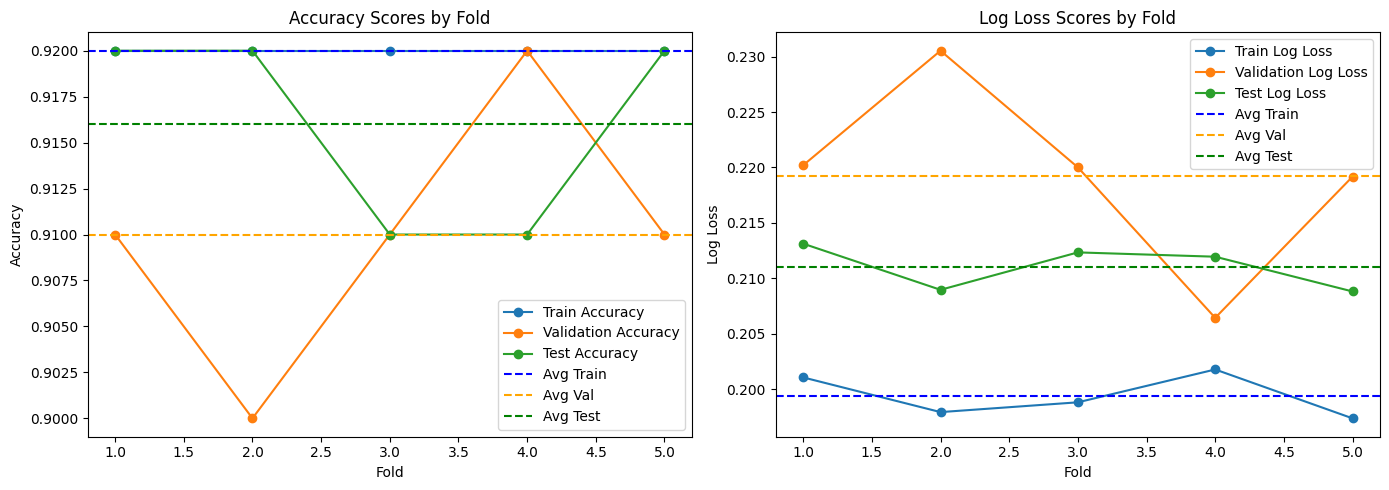

,Fold,Train Accuracy,Validation Accuracy,Test Accuracy,Train Log Loss,Validation Log Loss,Test Log Loss
0,1,0.92,0.91,0.920,0.201064,0.220198,0.213126
1,2,0.92,0.90,0.920,0.197936,0.230528,0.208964
2,3,0.92,0.91,0.910,0.198819,0.220010,0.212339
3,4,0.92,0.92,0.910,0.201781,0.206436,0.211950
4,5,0.92,0.91,0.920,0.197373,0.219171,0.208816
5,Average,0.92,0.91,0.916,0.199394,0.219269,0.211039


In [47]:

fold_rows = metrics_df[metrics_df['Fold'] != 'Average']
avg_row = metrics_df[metrics_df['Fold'] == 'Average']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(fold_rows['Fold'], fold_rows['Train Accuracy'], marker='o', label='Train Accuracy')
axes[0].plot(fold_rows['Fold'], fold_rows['Validation Accuracy'], marker='o', label='Validation Accuracy')
axes[0].plot(fold_rows['Fold'], fold_rows['Test Accuracy'], marker='o', label='Test Accuracy')
axes[0].axhline(avg_row['Train Accuracy'].values[0], color='blue', linestyle='--', label='Avg Train')
axes[0].axhline(avg_row['Validation Accuracy'].values[0], color='orange', linestyle='--', label='Avg Val')
axes[0].axhline(avg_row['Test Accuracy'].values[0], color='green', linestyle='--', label='Avg Test')
axes[0].set_title('Accuracy Scores by Fold')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[1].plot(fold_rows['Fold'], fold_rows['Train Log Loss'], marker='o', label='Train Log Loss')
axes[1].plot(fold_rows['Fold'], fold_rows['Validation Log Loss'], marker='o', label='Validation Log Loss')
axes[1].plot(fold_rows['Fold'], fold_rows['Test Log Loss'], marker='o', label='Test Log Loss')
axes[1].axhline(avg_row['Train Log Loss'].values[0], color='blue', linestyle='--', label='Avg Train')
axes[1].axhline(avg_row['Validation Log Loss'].values[0], color='orange', linestyle='--', label='Avg Val')
axes[1].axhline(avg_row['Test Log Loss'].values[0], color='green', linestyle='--', label='Avg Test')
axes[1].set_title('Log Loss Scores by Fold')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Log Loss')
axes[1].legend()
plt.tight_layout()
plt.show()
display(metrics_df)

# Optuna tuning (quick version)

In [48]:


DROP_COLS = ['Test_Record_Detail_ID']

def _minority_f1_at_best_threshold(y_true, p1, cls=0):
    """
    Return best F1 for minority class `cls` (0 by default) and the threshold used.
    We treat class-0 as "positive" by flipping probabilities: p0 = 1 - p1.
    Threshold grid is coarse for speed; widen if desired.
    """
    p0 = 1.0 - p1
    grid = np.linspace(0.05, 0.95, 19)
    y_true0 = (y_true == cls).astype(int)
    best_f1, best_t = -1.0, 0.5
    for t in grid:
        y_pred0 = (p0 >= t).astype(int)   # predict class-0 if p0 >= t
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true0, y_pred0, pos_label=1, average='binary', zero_division=0
        )
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_f1, best_t

def _cv_score_with_penalties(
    X, y, params, n_splits=5, rs=123, early_rounds=200,
    gap_lambda=0.10, f1gap_lambda=0.02
):
    """
    Minimize: mean(VAL logloss) + gap_lambda * mean(max(0, val-train logloss))
              + f1gap_lambda * mean(|F1_0(train) - F1_0(val)|)
    """
    Xc = X.drop(columns=DROP_COLS, errors='ignore')
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rs)

    # map sklearn-style params to xgb.train
    p = params.copy()
    p_xgb = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",            # optimize logloss during search
        "eta": p.get("learning_rate", 0.05),
        "max_depth": p.get("max_depth", 4),
        "min_child_weight": p.get("min_child_weight", 5.0),
        "gamma": p.get("gamma", 0.0),
        "subsample": p.get("subsample", 0.85),
        "colsample_bytree": p.get("colsample_bytree", 0.8),
        "reg_alpha": p.get("reg_alpha", 0.0),
        "reg_lambda": p.get("reg_lambda", 1.0),
        "max_delta_step": p.get("max_delta_step", 0.0),
        "sampling_method": p.get("sampling_method", "gradient_based"),
        "tree_method": "hist",
        "device": "cuda",
        "nthread": p.get("n_jobs", -1),
        "seed": p.get("seed", 10),
        # depthwise growth (since your outer loop uses max_depth)
        "grow_policy": "depthwise",
    }
    num_boost_round = int(p.get("n_estimators", 3000))
    scale_pos_weight = float(p.get("scale_pos_weight", 0.5))  # constrained by Optuna below

    val_lls, ll_gaps, f1_gaps = [], [], []
    for tr_idx, va_idx in skf.split(Xc, y):
        X_tr, X_va = Xc.iloc[tr_idx], Xc.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        p_xgb["scale_pos_weight"] = scale_pos_weight

        dtr = xgb.DMatrix(X_tr, label=y_tr)
        dva = xgb.DMatrix(X_va, label=y_va)

        booster = xgb.train(
            params=p_xgb,
            dtrain=dtr,
            num_boost_round=num_boost_round,
            evals=[(dtr, "train"), (dva, "val")],
            early_stopping_rounds=early_rounds,
            verbose_eval=False
        )

        # predict at best iteration
        try:
            it_end = booster.best_iteration + 1
            p_va = booster.predict(dva, iteration_range=(0, it_end))
            p_tr = booster.predict(dtr, iteration_range=(0, it_end))
        except Exception:
            it_end = getattr(booster, "best_ntree_limit", 0) or booster.best_iteration + 1
            p_va = booster.predict(dva, ntree_limit=it_end)
            p_tr = booster.predict(dtr, ntree_limit=it_end)

        # log losses
        ll_va = log_loss(y_va, p_va)
        ll_tr = log_loss(y_tr, p_tr)
        val_lls.append(ll_va)
        ll_gaps.append(max(0.0, ll_va - ll_tr))

        # minority class-0 F1 gap (train evaluated at the val-optimized threshold)
        f1_val, th = _minority_f1_at_best_threshold(y_va, p_va, cls=0)
        y_tr0 = (y_tr == 0).astype(int)
        y_pred_tr0 = ((1.0 - p_tr) >= th).astype(int)
        prec, rec, f1_tr, _ = precision_recall_fscore_support(
            y_tr0, y_pred_tr0, pos_label=1, average='binary', zero_division=0
        )
        f1_gaps.append(abs(f1_tr - f1_val))

    mean_val = float(np.mean(val_lls))
    mean_gap = float(np.mean(ll_gaps))
    mean_f1gap = float(np.mean(f1_gaps))
    return mean_val + gap_lambda * mean_gap + f1gap_lambda * mean_f1gap

def run_optuna_balanced_logloss(
    X_mvt, y_mvt, n_trials=60, inner_splits=5, seed=123,
    gap_lambda=0.10, f1gap_lambda=0.02
):
    """
    Search locally for lower VAL logloss with minority-class (0) alignment.
    Constrains scale_pos_weight to [0.1, 0.85].
    """
    def objective(trial: optuna.Trial):
        params = {
            "seed": 10,
            "n_estimators": 3000,  # ES will pick best iteration internally
            # --- search space (centered near your simple baseline) ---
            "learning_rate":   trial.suggest_float("learning_rate", 0.02, 0.08),
            "max_depth":       trial.suggest_int("max_depth", 3, 6),
            "min_child_weight":trial.suggest_float("min_child_weight", 2.0, 12.0),
            "gamma":           trial.suggest_float("gamma", 0.0, 2.0),
            "subsample":       trial.suggest_float("subsample", 0.60, 0.95),
            "colsample_bytree":trial.suggest_float("colsample_bytree", 0.60, 0.95),
            "reg_alpha":       trial.suggest_float("reg_alpha", 0.0, 2.5),
            "reg_lambda":      trial.suggest_float("reg_lambda", 0.5, 5.0),
            "max_delta_step":  trial.suggest_float("max_delta_step", 0.0, 5.0),
            "sampling_method": trial.suggest_categorical("sampling_method", ["gradient_based", "uniform"]),
            # constrain spw to [0.1, 0.85] exactly as requested
            "scale_pos_weight":trial.suggest_float("scale_pos_weight", 0.10, 0.85),
            "n_jobs": -1,
        }
        return _cv_score_with_penalties(
            X=X_mvt, y=y_mvt, params=params,
            n_splits=inner_splits, rs=seed,
            early_rounds=200, gap_lambda=gap_lambda, f1gap_lambda=f1gap_lambda
        )

    sampler = optuna.samplers.TPESampler(seed=seed)
    pruner  = optuna.pruners.MedianPruner(n_warmup_steps=10)
    study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

    # Warm-start with a reasonable baseline
    study.enqueue_trial({
        "learning_rate":   0.05,
        "max_depth":       4,
        "min_child_weight":5.0,
        "gamma":           0.5,
        "subsample":       0.85,
        "colsample_bytree":0.8,
        "reg_alpha":       0.5,
        "reg_lambda":      1.0,
        "max_delta_step":  0.0,
        "sampling_method": "gradient_based",
        "scale_pos_weight":0.5,   # within [0.1, 0.85]
    })

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    print("Best objective (lower is better):", study.best_value)
    print("Best params:", study.best_params)
    return study


In [49]:
# Run search
study = run_optuna_balanced_logloss(X_mvt, y_mvt, n_trials=60, inner_splits=5, seed=123)

# Build the model params for your outer loop
best_params = study.best_params.copy()
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",     # your loop uses logloss
    "seed": 10,
    "n_estimators": 3000,         # allow more trees; ES=5 in your loop will stop early
    "tree_method": "hist",
    "device": "cuda",
    "n_jobs": -1,
    "early_stopping_rounds": 5,   # your loop expects this in the constructor
})

# ---------------- your existing loop with tuned params ----------------
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

oof_predictions = np.zeros(len(X_mvt))
all_fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_mvt, y_mvt)):
    print(f"Fold {fold + 1}")

    X_train_fold, X_val_fold = X_mvt.iloc[train_idx], X_mvt.iloc[val_idx]
    y_train_fold, y_val_fold = y_mvt.iloc[train_idx], y_mvt.iloc[val_idx]

    X_train_model = X_train_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_val_model   = X_val_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_test_model  = Xmvt_test.drop(columns=['Test_Record_Detail_ID'], errors='ignore')

    # Model with tuned params (includes scale_pos_weight in [0.1, 0.85])
    xgb_mvt = XGBClassifier(**best_params)

    xgb_mvt.fit(
        X_train_model.values, y_train_fold.values,
        eval_set=[(X_val_model.values, y_val_fold.values)],
        verbose=False
    )

    oof_predictions[val_idx] = xgb_mvt.predict_proba(X_val_model.values)[:, 1]

    fold_results = evaluate_model(
        xgb_mvt,
        X_train_model, y_train_fold,
        X_val_model,   y_val_fold,
        X_test_model,  ymvt_test
    )
    all_fold_results.append(fold_results)
    display_evaluation_metrics(fold_results, cluster_name=f"Fold {fold + 1} Evaluation Results")

avg_log_loss = np.mean([
    fold["Validation"]["log_loss"] for fold in all_fold_results
    if fold["Validation"]["log_loss"] is not None
])
print(f"Average Validation Log Loss Across Folds: {avg_log_loss:.6f}")
print("Out-of-Fold Log Loss:", log_loss(y_mvt, oof_predictions))


[I 2025-08-27 20:49:57,878] A new study created in memory with name: no-name-25b472ce-de94-4d17-9564-47aae938cbf3


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-08-27 20:50:04,441] Trial 0 finished with value: 0.18160788373194175 and parameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5.0, 'gamma': 0.5, 'subsample': 0.85, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'max_delta_step': 0.0, 'sampling_method': 'gradient_based', 'scale_pos_weight': 0.5}. Best is trial 0 with value: 0.18160788373194175.
[I 2025-08-27 20:50:09,817] Trial 1 finished with value: 0.17678107889517852 and parameters: {'learning_rate': 0.0617881511358717, 'max_depth': 4, 'min_child_weight': 4.268514535642031, 'gamma': 1.1026295381657825, 'subsample': 0.851814139424947, 'colsample_bytree': 0.7480872610435613, 'reg_alpha': 2.4519104959615388, 'reg_lambda': 3.5817338236318847, 'max_delta_step': 2.4046595074218047, 'sampling_method': 'gradient_based', 'scale_pos_weight': 0.6467872805380311}. Best is trial 1 with value: 0.17678107889517852.
[I 2025-08-27 20:50:16,776] Trial 2 finished with value: 0.1822233571235548 and parameters: {

Fold 2


Fold 3


Fold 4


Fold 5


Average Validation Log Loss Across Folds: 0.168331
Out-of-Fold Log Loss: 0.16833074140150872


In [50]:
best_params

{'learning_rate': 0.05945948959797343,
 'max_depth': 5,
 'min_child_weight': 5.883319051019196,
 'gamma': 1.4541363979619986,
 'subsample': 0.6124225281952594,
 'colsample_bytree': 0.6181129660950725,
 'reg_alpha': 0.49370955512181797,
 'reg_lambda': 0.7885708631893332,
 'max_delta_step': 4.418918334656321,
 'sampling_method': 'gradient_based',
 'scale_pos_weight': 0.8473018113462933,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'seed': 10,
 'n_estimators': 3000,
 'tree_method': 'hist',
 'device': 'cuda',
 'n_jobs': -1,
 'early_stopping_rounds': 5}

# Optuna tuning 2

In [51]:
# =================== Optuna: lower logloss and align class-0 metrics ===================

DROP_COLS = ['Test_Record_Detail_ID']

# ------- learn from previous parameter set (depthwise) -------
anchor = dict(
    learning_rate   = 0.03016529362207945,
    max_depth       = 6,
    min_child_weight= 9.916093365773701,
    gamma           =  1.4049561255126464,
    subsample       = 0.6225909254413025,
    colsample_bytree= 0.621586184096436,
    reg_alpha       = 1.4164214458335949,
    reg_lambda      =  2.0495318881935423,
    max_delta_step  = 4.587606748629276,
    sampling_method = "gradient_based",
    scale_pos_weight= 0.8471077124915015,  # must stay within [0.10, 0.85]
)

def _minority_metrics_at_threshold(y_true, p1, t, minority_cls=0):
    """Compute (precision, recall, f1) for class-0 at threshold t on p0 = 1 - p1."""
    y_pos = (y_true == minority_cls).astype(int)     # 1 = class-0
    y_pred = ((1.0 - p1) >= t).astype(int)           # predict class-0 if p0 >= t
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_pos, y_pred, pos_label=1, average='binary', zero_division=0
    )
    return float(prec), float(rec), float(f1)

def _best_threshold_for_class0(y_val, p1_val):
    """Pick threshold on validation that maximizes F1 for class-0."""
    p0 = 1.0 - p1_val
    grid = np.linspace(0.05, 0.95, 19)               # widen to 0.01 step if desired
    y_pos = (y_val == 0).astype(int)
    best_f1, best_t = -1.0, 0.5
    for t in grid:
        y_pred = (p0 >= t).astype(int)
        _, _, f1, _ = precision_recall_fscore_support(
            y_pos, y_pred, pos_label=1, average='binary', zero_division=0
        )
        if f1 > best_f1:
            best_f1, best_t = float(f1), float(t)
    return best_t

def _objective_cv(
    trial, X, y, n_splits=5, rs=123, early_rounds=200,
    lambda_loggap=0.05, lambda_cls0=0.20
):
    """
    Minimize: mean(VAL logloss)
            + λ_loggap * mean( max(0, VAL_logloss - TRAIN_logloss) )
            + λ_cls0   * mean( avg(|Δprecision₀|, |Δrecall₀|, |ΔF1₀|) )
    """
    # ----- search space centered on provided params -----
    p = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",           # optimize logloss during search
        "tree_method": "hist",
        "device": "cuda",
        "nthread": -1,
        "seed": 10,
        "eta":            trial.suggest_float("learning_rate",   max(0.02, anchor["learning_rate"]-0.03), min(0.08, anchor["learning_rate"]+0.03)),
        "max_depth":      trial.suggest_int  ("max_depth",       max(3, anchor["max_depth"]-2),          min(7, anchor["max_depth"]+1)),
        "min_child_weight":trial.suggest_float("min_child_weight", max(2.0, anchor["min_child_weight"]-3.0), anchor["min_child_weight"]+6.0),
        "gamma":          trial.suggest_float("gamma",           max(0.0, anchor["gamma"]-0.8),          anchor["gamma"]+2.0),
        "subsample":      trial.suggest_float("subsample",       0.60,                                   0.98),
        "colsample_bytree":trial.suggest_float("colsample_bytree",0.60,                                  0.90),
        "reg_alpha":      trial.suggest_float("reg_alpha",       0.0,                                    2.5),
        "reg_lambda":     trial.suggest_float("reg_lambda",      0.5,                                    6.0),
        "max_delta_step": trial.suggest_float("max_delta_step",  0.0,                                    6.0),
        "sampling_method":trial.suggest_categorical("sampling_method", ["gradient_based", "uniform"]),
    }
    # constrained by  requirement
    spw = trial.suggest_float("scale_pos_weight", 0.10, 0.85)

    n_estimators = 3000  # let early stopping pick best iteration
    Xc = X.drop(columns=DROP_COLS, errors='ignore')
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rs)

    val_lls, log_gaps, m_gaps = [], [], []
    for tr_idx, va_idx in skf.split(Xc, y):
        X_tr, X_va = Xc.iloc[tr_idx], Xc.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        dtr = xgb.DMatrix(X_tr, label=y_tr)
        dva = xgb.DMatrix(X_va, label=y_va)

        # per-fold params
        p_fold = p.copy()
        p_fold["scale_pos_weight"] = spw

        booster = xgb.train(
            params=p_fold,
            dtrain=dtr,
            num_boost_round=n_estimators,
            evals=[(dtr, "train"), (dva, "val")],
            early_stopping_rounds=early_rounds,
            verbose_eval=False,
        )

        # predict at best iteration
        try:
            it_end = booster.best_iteration + 1
            p1_va = booster.predict(dva, iteration_range=(0, it_end))
            p1_tr = booster.predict(dtr, iteration_range=(0, it_end))
        except Exception:
            it_end = getattr(booster, "best_ntree_limit", 0) or booster.best_iteration + 1
            p1_va = booster.predict(dva, ntree_limit=it_end)
            p1_tr = booster.predict(dtr, ntree_limit=it_end)

        # logloss and gap
        ll_va = log_loss(y_va, p1_va)
        ll_tr = log_loss(y_tr, p1_tr)
        val_lls.append(ll_va)
        log_gaps.append(max(0.0, ll_va - ll_tr))

        # minority class-0 metrics at VAL-optimized threshold
        t = _best_threshold_for_class0(y_va, p1_va)
        prec_v, rec_v, f1_v = _minority_metrics_at_threshold(y_va, p1_va, t, minority_cls=0)
        prec_t, rec_t, f1_t = _minority_metrics_at_threshold(y_tr, p1_tr, t, minority_cls=0)
        m_gaps.append( (abs(prec_t-prec_v) + abs(rec_t-rec_v) + abs(f1_t-f1_v)) / 3.0 )

    mean_val = float(np.mean(val_lls))
    mean_loggap = float(np.mean(log_gaps))
    mean_mgap = float(np.mean(m_gaps))
    return mean_val + lambda_loggap * mean_loggap + lambda_cls0 * mean_mgap

def run_optuna_align_minority(
    X_mvt, y_mvt, n_trials=200, inner_splits=5, seed=123,
    lambda_loggap=0.05, lambda_cls0=0.20
):
    sampler = optuna.samplers.TPESampler(seed=seed)
    pruner  = optuna.pruners.MedianPruner(n_warmup_steps=10)
    study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

    # Warm-start with provided params
    study.enqueue_trial({
        "learning_rate":   anchor["learning_rate"],
        "max_depth":       anchor["max_depth"],
        "min_child_weight":anchor["min_child_weight"],
        "gamma":           anchor["gamma"],
        "subsample":       anchor["subsample"],
        "colsample_bytree":anchor["colsample_bytree"],
        "reg_alpha":       anchor["reg_alpha"],
        "reg_lambda":      anchor["reg_lambda"],
        "max_delta_step":  anchor["max_delta_step"],
        "sampling_method": anchor["sampling_method"],
        "scale_pos_weight":min(max(anchor["scale_pos_weight"], 0.10), 0.95),
    })

    def obj(trial):
        return _objective_cv(
            trial, X_mvt, y_mvt,
            n_splits=inner_splits, rs=seed,
            early_rounds=200,
            lambda_loggap=lambda_loggap,
            lambda_cls0=lambda_cls0
        )

    study.optimize(obj, n_trials=n_trials, show_progress_bar=True)
    print("Best objective:", study.best_value)
    print("Best params:", study.best_params)
    return study


In [52]:
# 1) Run the study
study = run_optuna_align_minority(X_mvt, y_mvt, n_trials=200, inner_splits=5, seed=123)

# 2) Build best_params for  loop (same constructor fields you use)
best_params = study.best_params.copy()
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "seed": 10,
    "n_estimators": 500,            #  loop uses 500 + ES=5
    "tree_method": "hist",
    "device": "cuda",
    "n_jobs": -1,
    "early_stopping_rounds": 5,
})

# 3) Run  existing 5-fold loop with tuned params
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

oof_predictions = np.zeros(len(X_mvt))
all_fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_mvt, y_mvt)):
    print(f"Fold {fold + 1}")

    X_train_fold, X_val_fold = X_mvt.iloc[train_idx], X_mvt.iloc[val_idx]
    y_train_fold, y_val_fold = y_mvt.iloc[train_idx], y_mvt.iloc[val_idx]

    X_train_model = X_train_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_val_model   = X_val_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_test_model  = Xmvt_test.drop(columns=['Test_Record_Detail_ID'], errors='ignore')

    xgb_mvt = XGBClassifier(**best_params)

    xgb_mvt.fit(
        X_train_model.values, y_train_fold.values,
        eval_set=[(X_val_model.values, y_val_fold.values)],
        verbose=False
    )

    oof_predictions[val_idx] = xgb_mvt.predict_proba(X_val_model.values)[:, 1]

    fold_results = evaluate_model(
        xgb_mvt,
        X_train_model, y_train_fold,
        X_val_model,   y_val_fold,
        X_test_model,  ymvt_test
    )
    all_fold_results.append(fold_results)
    display_evaluation_metrics(fold_results, cluster_name=f"Fold {fold + 1} Evaluation Results")

avg_log_loss = np.mean([
    fold["Validation"]["log_loss"] for fold in all_fold_results
    if fold["Validation"]["log_loss"] is not None
])
print(f"Average Validation Log Loss Across Folds: {avg_log_loss:.6f}")
print("Out-of-Fold Log Loss:", log_loss(y_mvt, oof_predictions))


[I 2025-08-27 20:57:18,485] A new study created in memory with name: no-name-5b24d2ca-a740-49fd-ad4b-92d69026caed


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-08-27 20:57:26,346] Trial 0 finished with value: 0.18286784131072786 and parameters: {'learning_rate': 0.03016529362207945, 'max_depth': 6, 'min_child_weight': 9.916093365773701, 'gamma': 1.4049561255126464, 'subsample': 0.6225909254413025, 'colsample_bytree': 0.621586184096436, 'reg_alpha': 1.4164214458335949, 'reg_lambda': 2.0495318881935423, 'max_delta_step': 4.587606748629276, 'sampling_method': 'gradient_based', 'scale_pos_weight': 0.8471077124915015}. Best is trial 0 with value: 0.18286784131072786.
[I 2025-08-27 20:57:30,655] Trial 1 finished with value: 0.18378300431458408 and parameters: {'learning_rate': 0.047973889338268655, 'max_depth': 5, 'min_child_weight': 8.95775644785153, 'gamma': 2.1486374789447416, 'subsample': 0.8733982085185139, 'colsample_bytree': 0.7269319380373382, 'reg_alpha': 2.4519104959615388, 'reg_lambda': 4.2665635622167475, 'max_delta_step': 2.8855914089061656, 'sampling_method': 'gradient_based', 'scale_pos_weight': 0.6467872805380311}. Best is t

Fold 2


Fold 3


Fold 4


Fold 5


Average Validation Log Loss Across Folds: 0.171968
Out-of-Fold Log Loss: 0.17196836728716697


In [53]:
best_params

{'learning_rate': 0.045516959832416166,
 'max_depth': 5,
 'min_child_weight': 11.83701030329873,
 'gamma': 2.3592161355133285,
 'subsample': 0.6783222488194494,
 'colsample_bytree': 0.871006608279671,
 'reg_alpha': 2.2765970748382625,
 'reg_lambda': 0.8469044235167233,
 'max_delta_step': 1.2667570635224112,
 'sampling_method': 'gradient_based',
 'scale_pos_weight': 0.8484517443570003,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'seed': 10,
 'n_estimators': 500,
 'tree_method': 'hist',
 'device': 'cuda',
 'n_jobs': -1,
 'early_stopping_rounds': 5}

# Optuna tuning 3

In [54]:
DROP_COLS = ['Test_Record_Detail_ID']

def anchor_from_best_params(best_params, spw_min=0.10, spw_max=0.85):
    """Center the next search on the previous Optuna result."""
    defaults = dict(
        learning_rate=0.05, max_depth=4, min_child_weight=5.0, gamma=0.5,
        subsample=0.85, colsample_bytree=0.80, reg_alpha=0.5, reg_lambda=1.0,
        max_delta_step=0.0, sampling_method="gradient_based", scale_pos_weight=0.5
    )
    a = {k: best_params.get(k, defaults[k]) for k in defaults}
    a["sampling_method"] = a["sampling_method"] if a["sampling_method"] in ("gradient_based","uniform") else "gradient_based"
    a["scale_pos_weight"] = float(np.clip(a["scale_pos_weight"], spw_min, spw_max))
    return a

In [55]:
def _best_t_for_cls0(y_val, p1_val):
    p0 = 1.0 - p1_val
    grid = np.linspace(0.05, 0.95, 19)
    y_pos = (y_val == 0).astype(int)
    best, thr = -1.0, 0.5
    for t in grid:
        y_pred = (p0 >= t).astype(int)
        _, _, f1, _ = precision_recall_fscore_support(y_pos, y_pred, average='binary', pos_label=1, zero_division=0)
        if f1 > best:
            best, thr = float(f1), float(t)
    return thr

def _cls0_metrics(y_true, p1, t):
    y_pos = (y_true == 0).astype(int)
    y_pred = ((1.0 - p1) >= t).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(y_pos, y_pred, average='binary', pos_label=1, zero_division=0)
    return float(prec), float(rec), float(f1)

def _objective_cv_v2(
    trial, X, y, anchor, n_splits=5, rs=123, early_rounds=200,
    lambda_loggap=0.05, lambda_cls0=0.30, lambda_f1std=0.05, lambda_worst=0.15
):
    # ----- local search around the anchor, slightly wider than before -----
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "device": "cuda",
        "nthread": -1,
        "seed": 10,
        "eta": trial.suggest_float("learning_rate",
                                   max(0.008, anchor["learning_rate"] - 0.03),
                                   min(0.06,  anchor["learning_rate"] + 0.03)),
        "max_depth": trial.suggest_int("max_depth",
                                       max(3, anchor["max_depth"] - 2),
                                       min(7, anchor["max_depth"] + 2)),
        "min_child_weight": trial.suggest_float("min_child_weight",
                                                max(2.0, anchor["min_child_weight"] - 5.0),
                                                anchor["min_child_weight"] + 10.0),
        "gamma": trial.suggest_float("gamma",
                                     max(0.0, anchor["gamma"] - 1.5),
                                     anchor["gamma"] + 2.5),
        "subsample": trial.suggest_float("subsample", 0.55, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.55, 0.95),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 3.5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.3, 8.0),
        "max_delta_step": trial.suggest_float("max_delta_step", 0.0, 6.0),
        "sampling_method": trial.suggest_categorical("sampling_method", ["gradient_based", "uniform"]),
        "grow_policy": "depthwise",
        "max_bin": trial.suggest_int("max_bin", 256, 1024, step=256),
        # constrained as requested
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.10, 0.85),
    }

    Xc = X.drop(columns=DROP_COLS, errors='ignore')
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rs)

    num_boost_round = 5000
    val_lls, log_gaps, c0_gaps, val_f1s, best_iters = [], [], [], [], []

    for tr_idx, va_idx in skf.split(Xc, y):
        X_tr, X_va = Xc.iloc[tr_idx], Xc.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        dtr = xgb.DMatrix(X_tr, label=y_tr)
        dva = xgb.DMatrix(X_va, label=y_va)

        booster = xgb.train(
            params=params,
            dtrain=dtr,
            num_boost_round=num_boost_round,
            evals=[(dtr, "train"), (dva, "val")],
            early_stopping_rounds=early_rounds,
            verbose_eval=False,
        )

        try:
            it_end = booster.best_iteration + 1
            p1_tr = booster.predict(dtr, iteration_range=(0, it_end))
            p1_va = booster.predict(dva, iteration_range=(0, it_end))
        except Exception:
            it_end = getattr(booster, "best_ntree_limit", 0) or booster.best_iteration + 1
            p1_tr = booster.predict(dtr, ntree_limit=it_end)
            p1_va = booster.predict(dva, ntree_limit=it_end)
        best_iters.append(it_end)

        # logloss + gap
        ll_tr = log_loss(y_tr, p1_tr)
        ll_va = log_loss(y_va, p1_va)
        val_lls.append(ll_va)
        log_gaps.append(max(0.0, ll_va - ll_tr))

        # class-0 alignment at VAL-optimal threshold
        t = _best_t_for_cls0(y_va, p1_va)
        pv, rv, fv = _cls0_metrics(y_va, p1_va, t)
        pt, rt, ft = _cls0_metrics(y_tr, p1_tr, t)
        c0_gaps.append((abs(pt-pv) + abs(rt-rv) + abs(ft-fv)) / 3.0)
        val_f1s.append(fv)

    mean_val   = float(np.mean(val_lls))
    mean_gap   = float(np.mean(log_gaps))
    mean_cgap  = float(np.mean(c0_gaps))
    worst_cgap = float(np.max(c0_gaps))
    f1_std     = float(np.std(val_f1s))

    # expose trees for later
    trial.set_user_attr("best_trees", int(np.median(best_iters)))

    return (mean_val
            + lambda_loggap * mean_gap
            + lambda_cls0   * mean_cgap
            + lambda_f1std  * f1_std
            + lambda_worst  * worst_cgap)


In [56]:
def run_optuna_logloss_aligned_v2(
    X_mvt, y_mvt, best_params_prev,
    n_trials=200, inner_splits=5, seed=123,
    lambda_loggap=0.05, lambda_cls0=0.30, lambda_f1std=0.05, lambda_worst=0.15
):
    anchor = anchor_from_best_params(best_params_prev, spw_min=0.10, spw_max=0.85)

    sampler = optuna.samplers.TPESampler(seed=seed)
    pruner  = optuna.pruners.MedianPruner(n_warmup_steps=10)
    study   = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

    # Warm start exactly at the anchor (already clipped SPW)
    study.enqueue_trial({
        "learning_rate":   anchor["learning_rate"],
        "max_depth":       anchor["max_depth"],
        "min_child_weight":anchor["min_child_weight"],
        "gamma":           anchor["gamma"],
        "subsample":       anchor["subsample"],
        "colsample_bytree":anchor["colsample_bytree"],
        "reg_alpha":       anchor["reg_alpha"],
        "reg_lambda":      anchor["reg_lambda"],
        "max_delta_step":  anchor["max_delta_step"],
        "sampling_method": anchor["sampling_method"],
        "scale_pos_weight":anchor["scale_pos_weight"],
        "max_bin":         512,   # a solid default for hist
    })

    def obj(trial):
        return _objective_cv_v2(
            trial, X_mvt, y_mvt, anchor,
            n_splits=inner_splits, rs=seed, early_rounds=200,
            lambda_loggap=lambda_loggap, lambda_cls0=lambda_cls0,
            lambda_f1std=lambda_f1std, lambda_worst=lambda_worst
        )

    study.optimize(obj, n_trials=n_trials, show_progress_bar=True)
    best_trees = study.best_trial.user_attrs.get("best_trees", 500)

    print("Best objective:", study.best_value)
    print("Best params:", study.best_params)
    print("Suggested n_estimators (median best trees):", best_trees)
    return study, int(best_trees)


In [57]:
best_params

{'learning_rate': 0.045516959832416166,
 'max_depth': 5,
 'min_child_weight': 11.83701030329873,
 'gamma': 2.3592161355133285,
 'subsample': 0.6783222488194494,
 'colsample_bytree': 0.871006608279671,
 'reg_alpha': 2.2765970748382625,
 'reg_lambda': 0.8469044235167233,
 'max_delta_step': 1.2667570635224112,
 'sampling_method': 'gradient_based',
 'scale_pos_weight': 0.8484517443570003,
 'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'seed': 10,
 'n_estimators': 500,
 'tree_method': 'hist',
 'device': 'cuda',
 'n_jobs': -1,
 'early_stopping_rounds': 5}

In [58]:
# Use the *previous* best_params you printed to continue the search:
# (Replace `best_params_prev` below with your dict—e.g., the one in your message)
best_params_prev = best_params

In [59]:

study, best_trees = run_optuna_logloss_aligned_v2(
    X_mvt, y_mvt, best_params_prev,
    n_trials=200, inner_splits=5, seed=123,
    lambda_loggap=0.05,   # calibration pressure
    lambda_cls0=0.30,     # stronger alignment of class-0 prec/rec/F1
    lambda_f1std=0.05,    # consistency across folds
    lambda_worst=0.15     # avoid outlier fold gaps
)

best_params = study.best_params.copy()
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "seed": 10,
    "n_estimators": best_trees,   # <<< use tuned trees, not fixed 500
    "tree_method": "hist",
    "device": "cuda",
    "n_jobs": -1,
    "early_stopping_rounds": 5,
})

# 3) Run  existing 5-fold loop with tuned params
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

oof_predictions = np.zeros(len(X_mvt))
all_fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_mvt, y_mvt)):
    print(f"Fold {fold + 1}")

    X_train_fold, X_val_fold = X_mvt.iloc[train_idx], X_mvt.iloc[val_idx]
    y_train_fold, y_val_fold = y_mvt.iloc[train_idx], y_mvt.iloc[val_idx]

    X_train_model = X_train_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_val_model   = X_val_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_test_model  = Xmvt_test.drop(columns=['Test_Record_Detail_ID'], errors='ignore')

    xgb_mvt = XGBClassifier(**best_params)

    xgb_mvt.fit(
        X_train_model.values, y_train_fold.values,
        eval_set=[(X_val_model.values, y_val_fold.values)],
        verbose=False
    )

    oof_predictions[val_idx] = xgb_mvt.predict_proba(X_val_model.values)[:, 1]

    fold_results = evaluate_model(
        xgb_mvt,
        X_train_model, y_train_fold,
        X_val_model,   y_val_fold,
        X_test_model,  ymvt_test
    )
    all_fold_results.append(fold_results)
    display_evaluation_metrics(fold_results, cluster_name=f"Fold {fold + 1} Evaluation Results")

avg_log_loss = np.mean([
    fold["Validation"]["log_loss"] for fold in all_fold_results
    if fold["Validation"]["log_loss"] is not None
])
print(f"Average Validation Log Loss Across Folds: {avg_log_loss:.6f}")
print("Out-of-Fold Log Loss:", log_loss(y_mvt, oof_predictions))


[I 2025-08-27 21:22:32,695] A new study created in memory with name: no-name-9617025d-cd14-463b-b45d-116dba4e6640


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-08-27 21:22:38,509] Trial 0 finished with value: 0.19104393610777826 and parameters: {'learning_rate': 0.045516959832416166, 'max_depth': 5, 'min_child_weight': 11.83701030329873, 'gamma': 2.3592161355133285, 'subsample': 0.6783222488194494, 'colsample_bytree': 0.871006608279671, 'reg_alpha': 2.2765970748382625, 'reg_lambda': 0.8469044235167233, 'max_delta_step': 1.2667570635224112, 'sampling_method': 'gradient_based', 'max_bin': 512, 'scale_pos_weight': 0.8484517443570003}. Best is trial 0 with value: 0.19104393610777826.
[I 2025-08-27 21:22:43,158] Trial 1 finished with value: 0.2085093636597043 and parameters: {'learning_rate': 0.04649802659085024, 'max_depth': 4, 'min_child_weight': 10.239782106761776, 'gamma': 3.0644752118448935, 'subsample': 0.8377875879142251, 'colsample_bytree': 0.7192425840497844, 'reg_alpha': 3.4326746943461544, 'reg_lambda': 5.573188987103447, 'max_delta_step': 2.8855914089061656, 'sampling_method': 'gradient_based', 'max_bin': 768, 'scale_pos_weight

Fold 2


Fold 3


Fold 4


Fold 5


Average Validation Log Loss Across Folds: 0.174094
Out-of-Fold Log Loss: 0.17409413933033152


# Best XGB

In [60]:
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

oof_predictions = np.zeros(len(X_mvt))
all_fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_mvt, y_mvt)):
    print(f"Fold {fold + 1}")

    # Split
    X_train_fold, X_val_fold = X_mvt.iloc[train_idx], X_mvt.iloc[val_idx]
    y_train_fold, y_val_fold = y_mvt.iloc[train_idx], y_mvt.iloc[val_idx]

    # (No PCA / no augmentation)
    X_train_model = X_train_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_val_model   = X_val_fold.drop(columns=['Test_Record_Detail_ID'], errors='ignore')
    X_test_model  = Xmvt_test.drop(columns=['Test_Record_Detail_ID'], errors='ignore')

    # Model
    best_xgb_mvt = XGBClassifier(
        **best_params
    )

    # Fit with early stopping on validation fold
    best_xgb_mvt.fit(
        X_train_model.values, y_train_fold.values,
        eval_set=[(X_val_model.values, y_val_fold.values)],
        verbose=False
    )

    # OOF preds
    oof_predictions[val_idx] = best_xgb_mvt.predict_proba(X_val_model.values)[:, 1]

    # Evaluate (no PCA features passed)
    fold_results = evaluate_model(
        best_xgb_mvt,
        X_train_model, y_train_fold,
        X_val_model,   y_val_fold,
        X_test_model,  ymvt_test
    )
    all_fold_results.append(fold_results)

    display_evaluation_metrics(fold_results, cluster_name=f"Fold {fold + 1} Evaluation Results")

# Aggregates
avg_log_loss = np.mean([fold["Validation"]["log_loss"] for fold in all_fold_results if fold["Validation"]["log_loss"] is not None])
print(f"Average Validation Log Loss Across Folds: {avg_log_loss}")
print("Out-of-Fold Log Loss:", log_loss(y_mvt, oof_predictions))


Fold 1


Fold 2


Fold 3


Fold 4


Fold 5


Average Validation Log Loss Across Folds: 0.17409407190269338
Out-of-Fold Log Loss: 0.17409413933033152


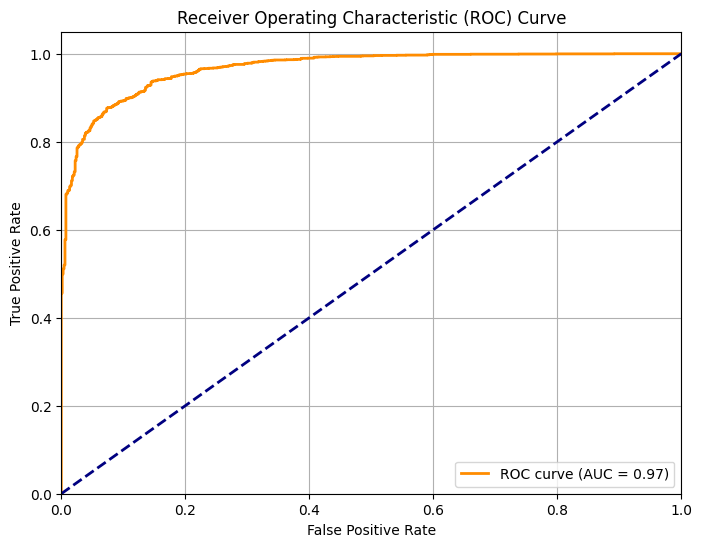

In [61]:
# ROC Curve and AUC for the final Optuna-tuned model
#  Use  validation set predictions and true labels
# Replace y_true and y_proba with your actual variables
y_true = y_val_fold  # or y_test, etc.
y_proba = best_xgb_mvt.predict_proba(X_val_fold.values)[:, 1]  # or X_test, etc.

fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

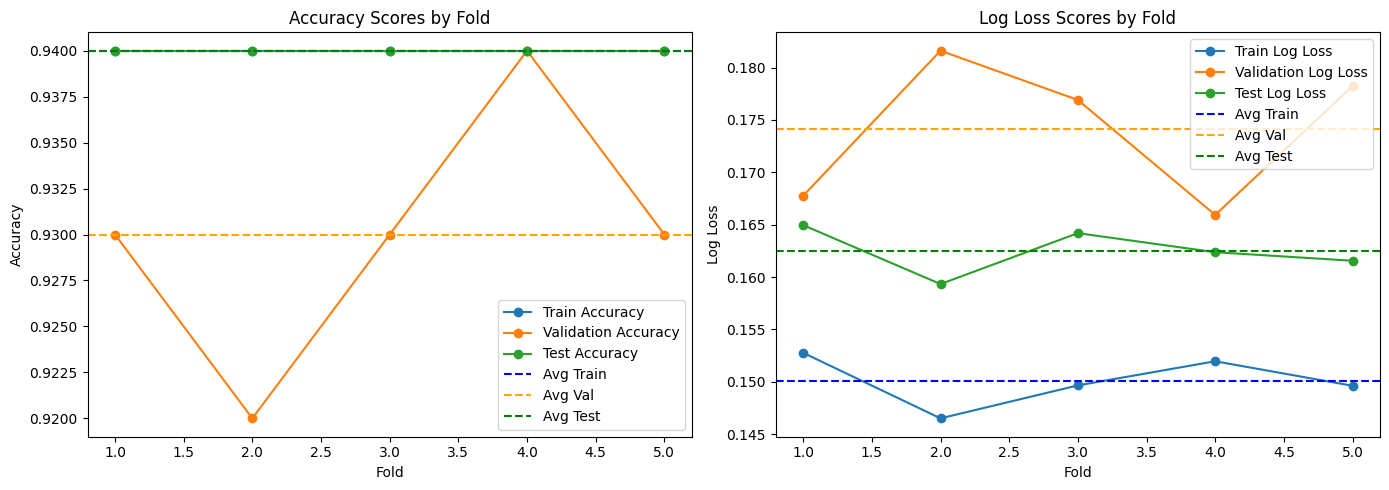

,Fold,Train Accuracy,Validation Accuracy,Test Accuracy,Train Log Loss,Validation Log Loss,Test Log Loss
0,1,0.94,0.93,0.94,0.152757,0.167766,0.164955
1,2,0.94,0.92,0.94,0.146500,0.181618,0.159329
2,3,0.94,0.93,0.94,0.149645,0.176913,0.164191
3,4,0.94,0.94,0.94,0.151952,0.165931,0.162370
4,5,0.94,0.93,0.94,0.149610,0.178242,0.161554
5,Average,0.94,0.93,0.94,0.150093,0.174094,0.162480


In [62]:
# Summarize metrics for each fold and show averages efficiently
def extract_accuracy(report):
    for line in report.split('\n'):
        if 'accuracy' in line:
            try:
                return float(line.split()[1])
            except Exception:
                return None
    return None

fold_metrics = []
for i, fold in enumerate(all_fold_results):
    train_acc = extract_accuracy(fold['Train']['classification_report'])
    val_acc = extract_accuracy(fold['Validation']['classification_report'])
    test_acc = extract_accuracy(fold['Test']['classification_report'])
    fold_metrics.append({
        'Fold': i + 1,
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Test Accuracy': test_acc,
        'Train Log Loss': fold['Train']['log_loss'],
        'Validation Log Loss': fold['Validation']['log_loss'],
        'Test Log Loss': fold['Test']['log_loss']
    })
metrics_df = pd.DataFrame(fold_metrics)
avg_metrics = metrics_df.mean(numeric_only=True)
avg_metrics['Fold'] = 'Average'
metrics_df = pd.concat([metrics_df, pd.DataFrame([avg_metrics])], ignore_index=True)

fold_rows = metrics_df[metrics_df['Fold'] != 'Average']
avg_row = metrics_df[metrics_df['Fold'] == 'Average']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(fold_rows['Fold'], fold_rows['Train Accuracy'], marker='o', label='Train Accuracy')
axes[0].plot(fold_rows['Fold'], fold_rows['Validation Accuracy'], marker='o', label='Validation Accuracy')
axes[0].plot(fold_rows['Fold'], fold_rows['Test Accuracy'], marker='o', label='Test Accuracy')
axes[0].axhline(avg_row['Train Accuracy'].values[0], color='blue', linestyle='--', label='Avg Train')
axes[0].axhline(avg_row['Validation Accuracy'].values[0], color='orange', linestyle='--', label='Avg Val')
axes[0].axhline(avg_row['Test Accuracy'].values[0], color='green', linestyle='--', label='Avg Test')
axes[0].set_title('Accuracy Scores by Fold')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[1].plot(fold_rows['Fold'], fold_rows['Train Log Loss'], marker='o', label='Train Log Loss')
axes[1].plot(fold_rows['Fold'], fold_rows['Validation Log Loss'], marker='o', label='Validation Log Loss')
axes[1].plot(fold_rows['Fold'], fold_rows['Test Log Loss'], marker='o', label='Test Log Loss')
axes[1].axhline(avg_row['Train Log Loss'].values[0], color='blue', linestyle='--', label='Avg Train')
axes[1].axhline(avg_row['Validation Log Loss'].values[0], color='orange', linestyle='--', label='Avg Val')
axes[1].axhline(avg_row['Test Log Loss'].values[0], color='green', linestyle='--', label='Avg Test')
axes[1].set_title('Log Loss Scores by Fold')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Log Loss')
axes[1].legend()
plt.tight_layout()
plt.show()
display(metrics_df)

In [63]:
best_xgb_mvt.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.6290218367569642,
 'device': 'cuda',
 'early_stopping_rounds': 5,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'feature_weights': None,
 'gamma': 2.1443796318009616,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.04748222197197323,
 'max_bin': 768,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': 5.579144565898985,
 'max_depth': 3,
 'max_leaves': None,
 'min_child_weight': 9.317946467991032,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1025,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 1.3711370460606882,
 'reg_lambda': 4.8790576413759394,
 'sampling_method': 'gradient_based',
 'scale_pos_weight': 0.8058174241765759,
 'subsa

In [64]:
# Export best_xgb_mvt model as a pickle file
import pickle

with open('mvt_v13.pkl', 'wb') as f:
    pickle.dump(best_xgb_mvt, f)

print('Model exported as mvt_v13.pkl')

Model exported as mvt_v13.pkl


In [65]:
X_val_fold.head()

,Voltage,Measured,Min,Max,Standard_Deviation,Average,Median,Bounce_Back,Drop,Slope_Bounce_Back,Slope_Drop,Min_Volt_Below_19,Max_Volt_19_Above,Start_Voltage,Time_To_Min_ms,Recovery_Time_ms,Area_0_200ms,Count_Below10,Curve_Kurtosis,Curve_Skew,Max_Rise_Rate_0_180,Max_Fall_Rate_0_180,Mean_Abs_Slope_0_180,Std_Slope_0_180,Mean_Abs_Accel_0_180,Max_Accel_0_180,Min_Accel_0_180,Norm_Energy_200ms,Rec_Slope,R_est,Spike_Count,Spike_Width_Mean_Ms,Hf_Energy,Spectral_Entropy,Min_Drop,Segment_Slope_Var,Zero_Cross_Rate,Step_Count_Sustained,Bp_Low,Bp_Mid,Bp_High,Bp_Mid_Ratio,Bp_High_Ratio,Resid_Spectral_Entropy,Rel_Below_Frac,Rel_Below_Longest_Ms,Tail_Ac1,Mid_Duty_Cycle_Low
8,12.32,599,8.92,12.36,0.720620,10.903714,10.950,2.91,3.43,0.030313,-0.571667,8.92,11.83,12.356,60,40.0,2109.9,10,3.107696,-0.179864,0.44,-3.44,0.301111,0.770490,0.545556,3.88,-3.45,3.522371,0.07275,0.068715,34,25.770478,0.585140,4.179306,-11.82,0.014048,0.287425,20,0.021707,0.129412,0.149437,5.961637,6.884108,3.926864,0.431138,620.0,0.000000,0.28
16,12.37,728,11.90,13.62,0.280195,12.500778,12.580,0.88,1.71,0.001803,-0.213750,11.90,12.78,13.614,80,500.0,2509.1,0,9.883609,1.791100,0.09,-1.34,0.111667,0.306581,0.173889,1.02,-1.34,3.446566,0.00176,0.028187,51,26.601307,0.588730,4.581263,-1.34,0.000284,0.239521,41,0.023344,0.183004,0.288242,7.839596,12.347832,4.093975,0.047904,80.0,-0.500000,0.00
19,12.81,505,8.99,12.82,0.635343,11.094790,11.110,3.28,3.83,0.018222,-0.478750,8.99,12.27,12.816,80,10.0,2148.6,10,4.808318,0.031867,0.55,-2.14,0.365000,0.556869,0.497778,1.35,-2.15,4.254653,0.32800,0.091010,49,25.574541,0.593865,4.588480,-2.14,0.000886,0.628743,2,0.008330,0.048220,0.216220,5.788927,25.957747,3.899062,0.029940,30.0,0.846413,0.00
22,11.97,518,8.39,11.96,0.769865,10.265755,10.295,3.15,3.57,0.032474,-0.595000,8.39,11.54,11.958,60,50.0,1989.5,35,3.262836,0.267960,0.26,-3.57,0.268889,0.803146,0.453333,3.83,-3.57,3.840734,0.06300,0.082703,17,55.813211,0.585838,4.197523,-11.54,0.012435,0.107784,18,0.032911,0.153719,0.204741,4.670760,6.221085,4.284624,0.413174,610.0,0.000000,0.27
29,12.65,503,9.24,12.63,0.716618,11.278977,11.340,3.05,3.37,0.038608,-0.561667,9.24,12.29,12.622,60,20.0,2177.5,5,3.269136,-0.238019,0.35,-3.37,0.272222,0.756436,0.456111,3.72,-3.35,4.329026,0.15250,0.080398,24,23.714100,0.588284,4.171115,-12.27,0.017606,0.155689,29,0.052276,0.167216,0.321915,3.198723,6.158005,4.289726,0.520958,790.0,0.000000,0.45


In [ ]:
# Load the exported best_xgb_mvt model from pickle file
import pickle

with open('best_xgb_mvt.pkl', 'rb') as f:
    loaded_xgb_mvt = pickle.load(f)

print('Model loaded as loaded_xgb_mvt')

In [70]:
best_xgb_mvt

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6290218367569642, device='cuda',
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=2.1443796318009616, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04748222197197323,
              max_bin=768, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=5.579144565898985, max_depth=3, max_leaves=None,
              min_child_weight=9.317946467991032, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1025,
              n_jobs=-1, num_parallel_tree=None, ...)